# Startups operations/close predictions [M1_31DS+]

<b>Описание задачи:</b> <br>
Для проекта предоставлены псевдо-реальные данные (реальные данные в которые добавлена синтетическая составляющая) о стартапах, функционировавших в период с 1970 по 2018 годы. <br>
Задача предсказать, какие из представленных стартапов закроются. <br>
Срок проведения соревнования на платформе Kaggle составляет 2 недели.

<b>Цели исследования:</b> <br>
1. Предсказание (преждевременного) закрытия стартапов. <br>
2. Выделение важных признаков / компонентов в данных, влияющих на целевой признак (закрытие стартапа).

<b>Ход исследования:</b> <br>
- загрузка данных;
- ознакомление с данными;
- предобработка данных;
- разведочный анализ;
- разработка синтетических признаков;
- проверка на МультиКоллинеарность;
- отбор финального набора признаков для машинного обучения;
- выбор и обучение моделей;
- оценка качества предсказания;
- анализ важности признаков.

# Импорт библиотек

Импортируем требуемые библиотеки:

In [1]:
import time
block_start = time.time()
very_start_time = time.time()

In [2]:
import numpy as np
import pandas as pd

In [3]:
# import matplotlib as mpl
# from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.linear_model import LinearRegression

In [5]:
# import phik

In [6]:
import shap

Зафиксируем константу `RANDOM_STATE`:

In [7]:
RS = 42
np_RS = np.random.RandomState(RS)

In [8]:
#_______________________________pep-8_79_digits_______________________________#

In [9]:
pd.options.display.max_colwidth = 150
pd.options.display.max_columns = 50

In [10]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 2.54'

# Загрузка

In [11]:
block_start = time.time()

Загрузка обучающих данных:

In [12]:
data = pd.read_csv('data\kaggle_startups_train_27042024.csv')
display(data.head())
data.info()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Загрузка тестовых данных:

In [13]:
action = pd.read_csv('data\kaggle_startups_test_27042024.csv')
display(action.head())
action.info()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


Загрузка примера представления результата:

In [14]:
sample = pd.read_csv('data\kaggle_startups_sample_submit_27042024.csv')
display(sample.head())
sample.info()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,closed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


По условию задания, дата формирования выгрузки ("текущая дата" для определения `lifetime`) = первое января 2018 года:

In [15]:
CURRENT_DATE = pd.to_datetime('2018-01-01')

In [16]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 0.28'

<b>Выводы:</b> <br>
Данные успешно загруены, <br>
В обучающей базе 52 514 записей о стартапах, <br>
В тестовой базе 13 125 записей о стартапах + в примере только наименование и статус.

# Ознакомление с данными

In [17]:
block_start = time.time()

Разделим столбцы обучающих данных на числовые и загруженные как текст:

In [18]:
data_num_columns = data.select_dtypes(exclude='object').columns
data_obj_columns = data.select_dtypes(include='object').columns
display(data_num_columns, data_obj_columns, 
        len(data.columns)-len(data_num_columns)-len(data_obj_columns))

Index(['funding_total_usd', 'funding_rounds'], dtype='object')

Index(['name', 'category_list', 'status', 'country_code', 'state_code',
       'region', 'city', 'founded_at', 'first_funding_at', 'last_funding_at',
       'closed_at'],
      dtype='object')

0

In [19]:
data[data_num_columns].describe()

,funding_total_usd,funding_rounds
count,4.244500e+04,52514.000000
mean,1.824826e+07,1.740679
std,1.871217e+08,1.374544
min,1.000000e+00,1.000000
25%,3.360000e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


Суммарный объём финансирования содержит пропуски, в то кремя как количество раундов - нет

In [20]:
data[data_obj_columns].describe()

,name,category_list,status,country_code,state_code,region,city,founded_at,first_funding_at,last_funding_at,closed_at
count,52513,50049,52514,47013,45752,46156,46156,52514,52514,52514,4915
unique,52513,22108,2,134,300,1036,4477,5401,4603,4305,3007
top,AeroDynEnergy,Software,operating,USA,CA,SF Bay Area,San Francisco,2012-01-01,2013-01-01,2014-01-01,2017-01-22
freq,1,3207,47599,29701,10217,6968,2824,2172,450,369,8


Среди полей, загруженных как текст, оказались столбцы с датами - их обработаем отдельно.

## Пропуски

In [21]:
display(data.isna().sum())

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Единственный пропуск в наименовании, <br>
2,5 тыс не заполненных категорий, <br>
более 5 тыс. пропусков в коде страны и штата, одинаковое количество в пропусках Городов и регионов, <br>
Большое количество пропусков в поле "дата закрытия" должно указывать на то, что стартап не закрыт и функционирует.

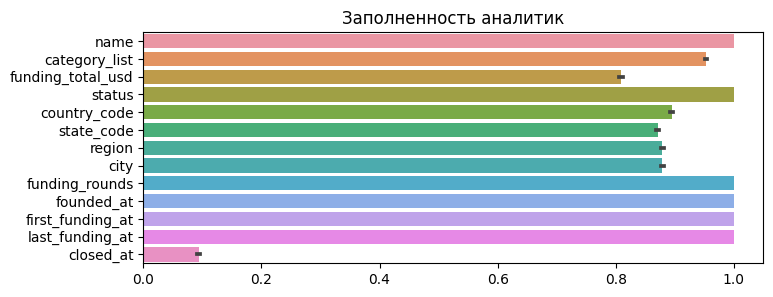

In [22]:
plt.rcParams['figure.figsize'] = (8, 3)
# plt.set_cmap(cm.viridis)
# plt.set_cmap('viridis')
sns.barplot(data=data.notna(), orient='h')
plt.title('Заполненность аналитик');

Взглянем на единственный стартап без имени:

In [23]:
display(data[data.name.isna()])

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-03-31


In [24]:
display(action.isna().sum())

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

В тестовых данных структура пропусков аналогична обучающим.

## Количество дубликатов в данных

Проверим наличие дубликатов с учётом наименования, наименований отдельно, и метрик без учёта имени:

In [25]:
pd.DataFrame([[
    data.name.duplicated().sum(),
    data.duplicated().sum(),
    data.drop(columns='name').duplicated().sum()],[
    action.name.duplicated().sum(),
    action.duplicated().sum(),
    action.drop(columns='name').duplicated().sum()
]], columns=['name', 'total', 'no_name'], index=['data','action'])

,name,total,no_name
data,0,0,10
action,0,0,0


Наименования уникальны, а без их учёта только 10 стартапов с идентичными метриками.<br>
Взглянем на них:

In [26]:
display(data[data.drop(columns='name').duplicated(keep=False)].sort_values(
    by=['funding_total_usd', 'country_code', 'category_list', 'founded_at']))

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
41653,OM Latam,Advertising,25000.0,operating,ARG,7,Buenos Aires,Buenos Aires,1,2011-01-01,2012-08-01,2012-08-01,NaN
51938,Logan,Advertising,25000.0,operating,ARG,7,Buenos Aires,Buenos Aires,1,2011-01-01,2012-08-01,2012-08-01,NaN
1487,American Gnuity,Media|News,670000.0,operating,USA,UT,Salt Lake City,Bountiful,1,2014-04-03,2011-08-19,2011-08-19,NaN
6710,America's Real Deal,Media|News,670000.0,operating,USA,UT,Salt Lake City,Bountiful,1,2014-04-03,2011-08-19,2011-08-19,NaN
1485,Super!dea,NaN,NaN,operating,KOR,11,Seoul,Seoul,1,2014-01-01,2015-06-01,2015-06-01,NaN
6536,theCre8tion,NaN,NaN,operating,KOR,11,Seoul,Seoul,1,2014-01-01,2015-06-01,2015-06-01,NaN
973,TraNet'te,NaN,NaN,operating,USA,CA,SF Bay Area,Palo Alto,1,2014-01-01,2014-01-15,2014-01-15,NaN
47769,InterStelNet,NaN,NaN,operating,USA,CA,SF Bay Area,Palo Alto,1,2014-01-01,2014-01-15,2014-01-15,NaN
8237,Xyrosoft,Software,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-01,2014-08-25,2014-08-25,NaN
9648,Kliptap,Software,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-01,2014-08-25,2014-08-25,NaN


В дубликатах много пропусков, однако всё-таки это уникальные компании. <br>
Удаление дубликатов сделаем перед обучением моделей.

## Общая сумма финансирования в USD

In [27]:
data.funding_total_usd.value_counts(dropna=False).head()

NaN          10069
1000000.0      899
100000.0       786
500000.0       772
2000000.0      650
Name: funding_total_usd, dtype: int64

Самые популярные размеры суммарных инвестиций - круглые цифры: <br>
100 тыс., <br>
0.5 млн, <br>
1 млн <br>
и 2 млн долларов.

In [28]:
action.funding_total_usd.value_counts(dropna=False).head()

NaN          2578
1000000.0     237
500000.0      200
100000.0      186
2000000.0     154
Name: funding_total_usd, dtype: int64

В тестовых данных такая же картина.

Взглянем на частотное распределение размеров суммарных инвестиций:

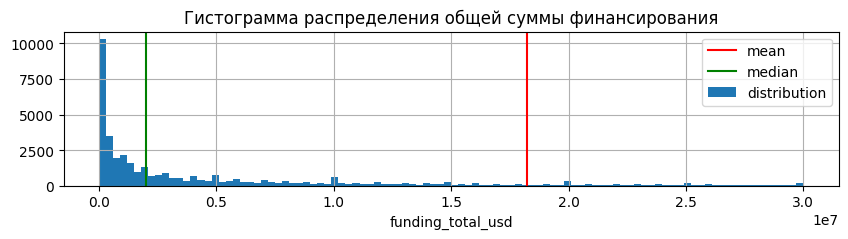

In [29]:
plt.rcParams['figure.figsize'] = (10, 2)
data.funding_total_usd[data.funding_total_usd < 30001000].hist(bins=100)
plt.axvline(data.funding_total_usd.mean(),0,1, color='red')
plt.axvline(data.funding_total_usd.median(),0,1, color='green')
plt.legend(['mean','median','distribution'])
plt.xlabel('funding_total_usd')
plt.title('Гистограмма распределения общей суммы финансирования');

Распределение абсолютного значения выглядит экспоненциальным - это не наглядно. <br>
С учётом того, что минимальное значение из заполненных составляет 1 доллар, <br>
и исходя из характера "круглых сумм", <br>
попробуем представить эту величину как десятичный логарифм:

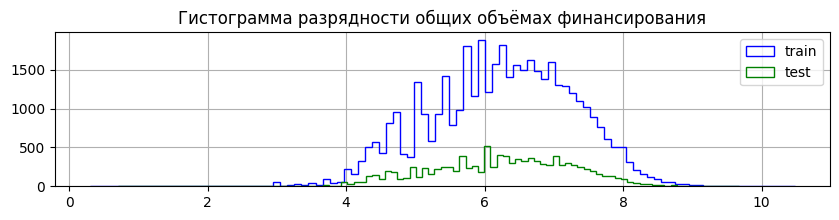

In [30]:
data_funding_total_log10 = pd.Series(
    np.log10(data.funding_total_usd).fillna(0),
    index=data.index, name='funding_total_log10')
action_funding_total_log10 = pd.Series(
    np.log10(action.funding_total_usd).fillna(0),
    index=action.index, name='funding_total_log10')
plt.rcParams['figure.figsize'] = (10, 2)
data_funding_total_log10[data_funding_total_log10>0].hist(
    bins=100, color='blue', histtype='step')
action_funding_total_log10[action_funding_total_log10>0].hist(
    bins=100, color='green', histtype='step')
plt.legend(['train','test'])
plt.title('Гистограмма разрядности общих объёмах финансирования');

Действительно, распределение прологорифмированного параметра визуально ближе к нормальному. <br>
Рассмотрим включение нового / замену исходного признака на этапе выбора факторов для модели.

## Количество раундов финансирования

In [31]:
pd.DataFrame([
data.funding_rounds.describe(),
action.funding_rounds.describe()], index=['train','test']).round(2)

,count,mean,std,min,25%,50%,75%,max
train,52514.0,1.74,1.37,1.0,1.0,1.0,2.0,19.0
test,13125.0,1.71,1.32,1.0,1.0,1.0,2.0,15.0


В обучающих и тестовых данных количество раундов финансирования представлено целым числом от 1, что соответствует смыслу этого показателя. <br>
В каждой выборке больше половины наблюдений имеют один раунд.

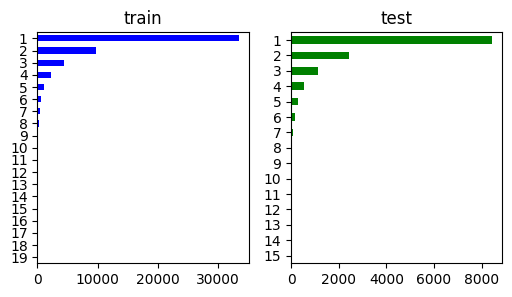

In [32]:
plt.rcParams['figure.figsize'] = (6, 3)
plt.subplots(1,2)
plt.subplot(1,2,1)
data.funding_rounds.value_counts(
    dropna=False).sort_index(ascending=False).plot(kind='barh', 
                                                   color='blue')
plt.title('train')
plt.subplot(1,2,2)
action.funding_rounds.value_counts(
    dropna=False).sort_index(ascending=False).plot(kind='barh', 
                                                   color='green')
plt.title('test');

## Целевой признак

Целевой бинарный категориальный признак представлен в обучающих данных и в данных примера:

In [33]:
pd.DataFrame([
    data.status.value_counts(dropna=False), 
    sample.status.value_counts(dropna=False)], 
             index=['train','sample'])

,operating,closed
train,47599,4915
sample,6542,6583


Для удобства, обозначим статус "закрытого" стартапа (минорный класс), как целевую "положительную" метку. Таким образом, поле статус будет отвечать на вопрос, является ли стартап закрытым?

In [34]:
POS_LABEL = data.status.value_counts().index[1]
display(POS_LABEL)

'closed'

## Название стартапа

In [35]:
pd.DataFrame([[
    data.name.isna().sum(), 
    data.name.nunique(), 
    data.name.duplicated().sum(), 
    data.name.str.len().max(),
    data.name.str.len().min()],[
    action.name.isna().sum(), 
    action.name.nunique(), 
    action.name.duplicated().sum(), 
    action.name.str.len().max(),
    action.name.str.len().min()]], 
             index=['train','test'], 
             columns=['n_na','nunique','duplicated','len_max','len_min']
            ).astype(int)

,n_na,nunique,duplicated,len_max,len_min
train,1,52513,0,97,1
test,0,13125,0,61,2


В обучающих и в тестовых данных наименование стартапа - уникальный признак, по сути, "ключ". 
В обучающих данных содержится единственный пропуск.

## Список категорий, к которым относится стартап

In [36]:
display(data.category_list.head())

0          Online Reservations|Restaurants
1    Manufacturing|Medical|Medical Devices
2                            Biotechnology
3                              Health Care
4                            Manufacturing
Name: category_list, dtype: object

Признак "список категорий" представляет из себя строковые данные, разделённые символом `|`. <br>
Подсчитаем количество разделителей:

In [37]:
pd.DataFrame([[
    data.category_list.nunique(), 
    data.category_list.isna().sum(), 
    data.category_list.str.count('\|').max()+1], [
    action.category_list.nunique(), 
    action.category_list.isna().sum(), 
    action.category_list.str.count('\|').max()+1]],
             index=['train','test'], 
             columns=['nunique','n_na','max_n'])

,nunique,n_na,max_n
train,22108,2465,40.0
test,6206,591,44.0


Максимальное количество категорий в одном списке достигает 40 в обучающих и 44 в тестовых данных. <br>
Среди значений списка есть одинаковые, однако количество уникальных наборов составляет по половине датасэта.

## Даты

Определим совпадающие столбцы с датами в список:

In [38]:
date_columns = ['founded_at',
                'first_funding_at', 
                'last_funding_at']

Теперь, на дополнительных таблицах преобразуем даты в соответствующий формат:

In [39]:
train_dates = data[['status']+date_columns+['closed_at']].copy()
test_dates = action[date_columns+['lifetime']].copy()

for t in [train_dates, test_dates]:
    for c in date_columns+['closed_at']:
        try:
            t[c] = pd.to_datetime(t[c], format='%Y-%m-%d')
        except: pass

display(train_dates.dtypes, test_dates.dtypes)

status                      object
founded_at          datetime64[ns]
first_funding_at    datetime64[ns]
last_funding_at     datetime64[ns]
closed_at           datetime64[ns]
dtype: object

founded_at          datetime64[ns]
first_funding_at    datetime64[ns]
last_funding_at     datetime64[ns]
lifetime                     int64
dtype: object

Даты успешно сконвертированы, проверим "дату отчёта"

In [40]:
display(CURRENT_DATE)

Timestamp('2018-01-01 00:00:00')

и теперь рассчитаем срок жизни для обучающих данных, <br>
а так же целевой признак и дату закрытия для тестовых:

In [41]:
start = time.time()
train_dates['lifetime'] = (
    train_dates.closed_at - train_dates.founded_at
).dt.days
train_dates.lifetime = train_dates.lifetime.fillna(
    (CURRENT_DATE-train_dates.founded_at).dt.days
).astype('int64')

train_dates.status = train_dates.status==POS_LABEL

test_dates['closed_at'] = test_dates.founded_at + pd.to_timedelta(
    test_dates.lifetime, unit='D'
)
test_dates.closed_at = test_dates.closed_at[
test_dates.closed_at < CURRENT_DATE
]

test_dates['status'] = test_dates.closed_at<CURRENT_DATE

test_dates = test_dates[train_dates.columns]

display(time.time() - start)

0.012997865676879883

Построим гистограммы по датам открытия и закрытия на обучающих данных:

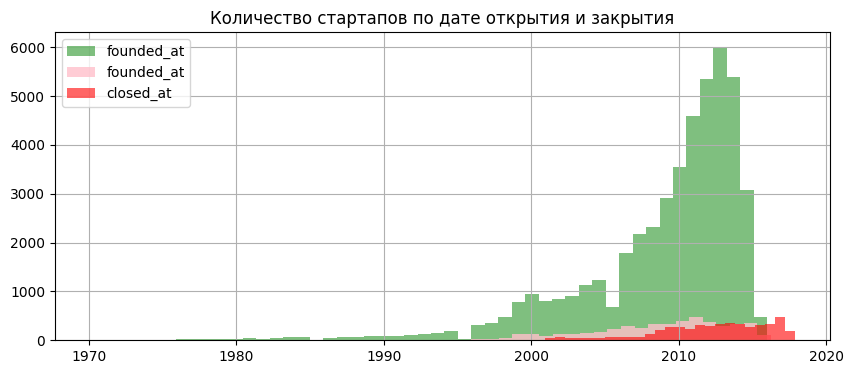

In [42]:
plt.rcParams['figure.figsize'] = (10, 4)
ax = train_dates.founded_at[~train_dates.status].hist(
    bins=50, color='green', alpha=0.5, legend=True)
train_dates.founded_at[train_dates.status].hist(
    bins=50, color='pink', alpha=0.8, ax=ax, legend=True)
train_dates.closed_at.hist(
    bins=50, color='red', alpha=0.6, ax=ax, legend=True)
plt.title('Количество стартапов по дате открытия и закрытия');

И для тестовых:

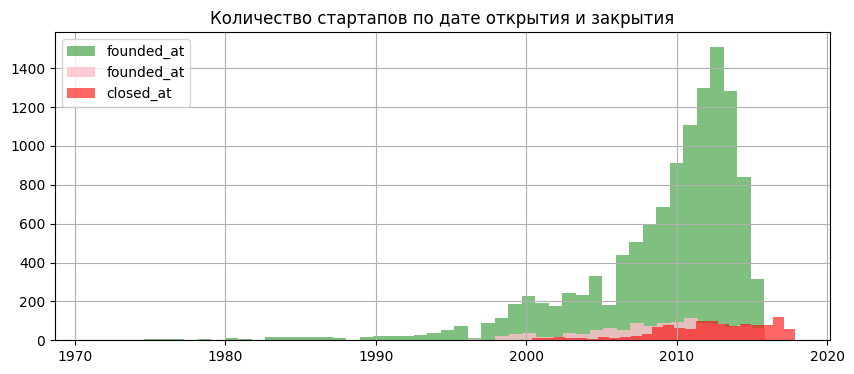

In [43]:
plt.rcParams['figure.figsize'] = (10, 4)
ax = test_dates.founded_at[~test_dates.status].hist(
    bins=50, color='green', alpha=0.5, legend=True)
test_dates.founded_at[test_dates.status].hist(
    bins=50, color='pink', alpha=0.8, ax=ax, legend=True)
test_dates.closed_at.hist(bins=50, color='red', alpha=0.6, ax=ax, legend=True)
plt.title('Количество стартапов по дате открытия и закрытия');

Даты открытия и первого / последнего финансирования для обучающих данных:

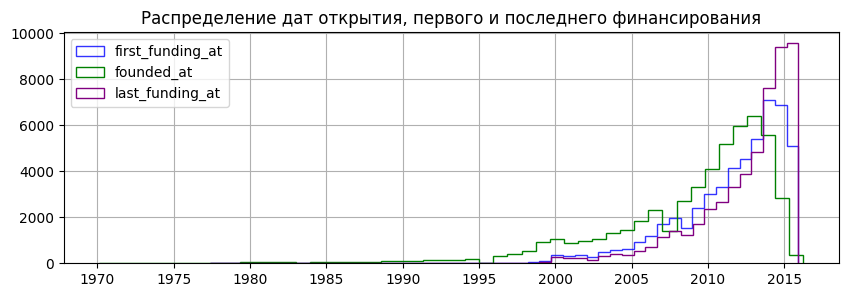

In [44]:
plt.rcParams['figure.figsize'] = (10, 3)
ax = train_dates.first_funding_at.hist(
    bins=50, color='blue', alpha=0.8, legend=True, histtype='step')
train_dates.founded_at.hist(
    bins=50, color='green', ax=ax, legend=True, histtype='step')
train_dates.last_funding_at.hist(
    bins=50, color='purple', legend=True, histtype='step')
plt.legend(loc='upper left')
plt.title('Распределение дат открытия, первого и последнего финансирования');

И для тестовых:

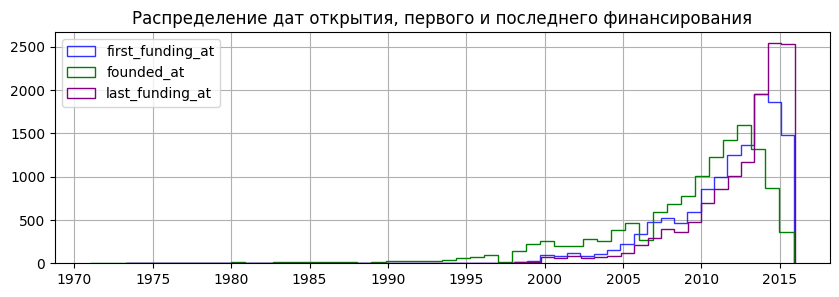

In [45]:
plt.rcParams['figure.figsize'] = (10, 3)
ax = test_dates.first_funding_at.hist(
    bins=50, color='blue', alpha=0.8, legend=True, histtype='step')
test_dates.founded_at.hist(
    bins=50, color='green', ax=ax, legend=True, histtype='step')
test_dates.last_funding_at.hist(
    bins=50, color='purple', ax=ax, legend=True, histtype='step')
plt.legend(loc='upper left')
plt.title('Распределение дат открытия, первого и последнего финансирования');

Благодаря датам и сроку жизни в тестовых данных, есть рассчитанное значение целевого признака для самостоятельной проверки результатов моделирования при помощи указанной метрики (f1).

## Географические признаки

Определим признаки, связанные с географией стартапов:

In [46]:
loc_columns = ['country_code', 'state_code', 'region', 'city']

Подсчитаем количество пропусков в географических признаках:

In [47]:
pd.DataFrame([
    data[loc_columns].isna().sum(),
    action[loc_columns].isna().sum()], 
             index=['train','test'])

,country_code,state_code,region,city
train,5501,6762,6358,6358
test,1382,1695,1589,1587


Для обучающих данных выведем описательную статистику:

In [48]:
data[loc_columns].describe()

,country_code,state_code,region,city
count,47013,45752,46156,46156
unique,134,300,1036,4477
top,USA,CA,SF Bay Area,San Francisco
freq,29701,10217,6968,2824


Итак, самым популярным местом стартапов оказался Сан-Франциско из Калифорнии, США. <br>
Посмотрим, отличается ли ситуация в тестовых данных:

In [49]:
action[loc_columns].describe()

,country_code,state_code,region,city
count,11743,11430,11536,11538
unique,96,235,688,2117
top,USA,CA,SF Bay Area,San Francisco
freq,7428,2552,1750,656


Нет, всё так же: Самые многочисленные - стартапы из Сан-Франциско)

## Выводы по загрузке и ознакомению

1. для суммы финансирования целесообразно рассмотреть производный признак (десятичный логарифм)
2. Для  количества раундов финансирования може отказаться полезным бинарный признак наличия более одного раунда
3. Название стартапа уникально, может стоит выделить группы типа начинающиеся с "A " или "The"...
4. Текстовые списки категорий слишком уникальны, стоит разбить их по разделителю и посмотреть на первую или самую популярную категорию
5. Признаки дат корректны и заполнены без пропусков, благодаря датам рассчитан целевой признак тестовых данных для проверки
6. Географические признаки заполены достаточно плохо, искусственное заполенение пропусков приведёт к существенному сдвигу структуры, целесообразнее будет работать с показателем заполненности и только со списком стран.
7. Целевой бинарный категориальный признак определяет задачу бинарной классификации.

In [50]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 7.42'

# Предварительная обработка данных

In [51]:
block_start = time.time()

Сравним списки полей в обучающих данных для приведения к единой структуре:

In [52]:
pd.DataFrame([data.columns, 
              action.columns], 
             index=['train','test']).T

,train,test
0,name,name
1,category_list,category_list
2,funding_total_usd,funding_total_usd
3,status,country_code
4,country_code,state_code
5,state_code,region
6,region,city
7,city,funding_rounds
8,funding_rounds,founded_at
9,founded_at,first_funding_at


Определим числовые признаки, подлежащие заполнению пропусков и последующей стандартизации, <br>
а так же категориальные признаки, которые на данном этапе просто проверим на заполенность:

In [53]:
funding_cols = ['funding_total_usd', 'funding_rounds']
bool_cols_1 = ['name', 
               'category_list',
               'country_code', 'state_code', 'region', 'city']

Создадим таблицы обучающих и тестовых признаков, а также бинарные поля целевого признака:

In [54]:
X_train = data[funding_cols].merge(
    train_dates[date_columns+['lifetime']], 
    how='left', left_index=True, right_index=True)
for c in date_columns:
    X_train[c] = pd.to_numeric(X_train[c])
for c in bool_cols_1:
    X_train[c] = data[c].notna()

y_train = train_dates.status.astype(int)

X_test = action[funding_cols].merge(
    test_dates[date_columns+['lifetime']], 
    how='left', left_index=True, right_index=True)
for c in date_columns:
    X_test[c] = pd.to_numeric(X_test[c])
for c in bool_cols_1:
    X_test[c] = action[c].notna()

y_test = test_dates.status.astype(int)

display(X_train.tail(1), y_train.value_counts(), 
        X_test.tail(1), y_test.value_counts())

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,name,category_list,country_code,state_code,region,city
52513,270820.0,1,1383436800000000000,1402617600000000000,1402617600000000000,1520,True,True,True,True,True,True


0    47599
1     4915
Name: status, dtype: int64

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,name,category_list,country_code,state_code,region,city
13124,50250000.0,6,1041379200000000000,1168905600000000000,1353456000000000000,5479,True,True,True,True,True,True


0    11892
1     1233
Name: status, dtype: int64

Определим, что общая сумма финансирования среди заполенных значений имеет минимальное 1 доллар, <br>
а также с учётом производного логарифмического поля, <br>
определим заполнитель пропусков для суммы финансирования как 1:

In [55]:
FUNDING_IMPUTER = 1

Для исходных числовых признаков запрограммируем пайплайн с заполнителем пропусков и скейлером:

In [56]:
funding_pipe = Pipeline(
    [('funding_imp',
      SimpleImputer(
          missing_values=np.nan,
          fill_value=FUNDING_IMPUTER,
          strategy='constant')),
     ('funding_scaler',
      StandardScaler())])

display(funding_pipe)

Pipeline(steps=[('funding_imp',
                 SimpleImputer(fill_value=1, strategy='constant')),
                ('funding_scaler', StandardScaler())])

Для прочих числовых признаков (в том числе признаков с датами), задекларируем просто скейлер:

In [57]:
scaler_pipe = Pipeline(
    [('scaler', StandardScaler())])

display(scaler_pipe)

Pipeline(steps=[('scaler', StandardScaler())])

Определим поля для первичного масштабирования как поля дат и срока жизни стартапов:

In [58]:
scaling_cols_1 = date_columns+['lifetime']

Объявим Трансформатор для указанных списков признаков:

In [59]:
prepro_step_1 = ColumnTransformer(
    [
        ('funding_scaler', funding_pipe, funding_cols),
        ('scaler', scaler_pipe, scaling_cols_1),
        ],
    remainder='passthrough'
)
display(prepro_step_1)

ColumnTransformer(remainder='passthrough',
                  transformers=[('funding_scaler',
                                 Pipeline(steps=[('funding_imp',
                                                  SimpleImputer(fill_value=1,
                                                                strategy='constant')),
                                                 ('funding_scaler',
                                                  StandardScaler())]),
                                 ['funding_total_usd', 'funding_rounds']),
                                ('scaler',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['founded_at', 'first_funding_at',
                                  'last_funding_at', 'lifetime'])])

Проверим его работу, передав ему таблицы с факторами: 

In [60]:
start = time.time()
X_train_ = pd.DataFrame(prepro_step_1.fit_transform(X_train),
                       index=X_train.index, 
                       columns=X_train.columns,)
X_test_ = pd.DataFrame(prepro_step_1.transform(X_test),
                       index=X_test.index, 
                       columns=X_test.columns,)
display(f'time {round(time.time() - start,2)} sec.', 
        X_train_.shape, X_test_.shape)

'time 0.03 sec.'

(52514, 12)

(13125, 12)

Предобработка выполнилась успешно. <br>
Теперь проверим, сможет ли модель МО обучиться на базовых данных, и какую метрику f1 она продемострирует:

In [61]:
start = time.time()
model = KNeighborsClassifier()
model.fit(X_train_, y_train)
proba = model.predict(X_test_)
_ = f1_score(y_true=y_test, y_pred=proba)

display(f'time {round(time.time() - start,2)} sec.', 
        f'f1_score {round(_, 5)}')

'time 0.97 sec.'

'f1_score 0.95916'

95% - очень неплохо для базового предсказания. <br>
Попробуем убрать признак "срок жизни" стартапа и оценим разницу в метрике:

In [62]:
start = time.time()
model = KNeighborsClassifier()
model.fit(X_train_.drop(columns=['lifetime']), y_train)
proba = model.predict(X_test_.drop(columns=['lifetime']))
_ = f1_score(y_true=y_test, y_pred=proba)

display(f'time {round(time.time() - start,2)} sec.', 
        f'f1_score {round(_, 5)}')

'time 0.93 sec.'

'f1_score 0.18204'

18% - очень мало для модели классификации. Получается, признак `lifetime` является слишком значимым для простейшей модели.

<b>Выводы: </b> <br>
1. Исходные признаки разделены на числовые, требующие заполнения, полностью заполенные числовые и бинарные по заполенности категорий.
2. Для каждого вида прописаны отдельные обработчики, а также единый Трансформатор для всей таблицы признаков.
3. Структура призанков приведена в единый формат для обучающего и тестового набора данных, модель МО успешно проверена на результатах предобработки.

In [63]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 2.17'

# Разработка новых синтетических признаков

In [64]:
block_start = time.time()

## name_

Попробуем поискать интересные особенности в названиях стартапов: <br>
например, начинающиеся с неопределённого артикля "A":

In [65]:
data.name[data.name.str.startswith('A ', na=False)]

8243      A Family First Community Services
10132                 A Green Night's Sleep
13833                           A Star Pets
15198                        A Tale Unfolds
15466                    A V.E.T.S.c.a.r.e.
20082            A vida é feita de Desconto
23430                    A Pooches Pleasure
24201                         A Suite Salon
26905                       A Curated World
29126    A Better Tomorrow Treatment Center
29134                         A Class Limos
29892                        A Dance for Me
34761                        A Smarter City
42128                                A Plus
44315                A and A Travel Service
46934              A Little Easier Recovery
48342                 A & A Custom Cornhole
48593                           A la Mobile
49337                        A Break Please
Name: name, dtype: object

In [66]:
action.name[action.name.str.startswith('A ', na=False)].count()

6

Слишком мало для формирования отдельного признака. <br>
Попробуем определённый артикль "The":

In [67]:
data.name[data.name.str.startswith(('The ', 'THE '), na=False)]

18                           The Glassbox
26       The Center from Health Promotion
61                         The Box Populi
292                      The Ticket Fairy
381                      The Beauty Tribe
                       ...               
51638                 The Otherland Group
51978                       The Mad Video
52052             The Influential Network
52063                   The Viridan Group
52148                   The Charnwood Pub
Name: name, Length: 359, dtype: object

Уже лучше, поищем инкорпорации:

In [68]:
data.name[data.name.str.contains(' inc', 
                                 case=False, na=False, regex=False
                                )].sort_values()

19914    1-800-PublicRelations, Inc.
41128        20/20 Gene Systems Inc.
4458                          21 Inc
6253                     2Morrow Inc
22476                        2U Inc.
                    ...             
40629           twoXAR, Incorporated
607                       uniRow Inc
39710                 weBounty, Inc.
37798           xF Technologies Inc.
16451         xTV Networks, US, Inc.
Name: name, Length: 1158, dtype: object

И самое любопытное для стартапов, жаждущих финансирования и возможно закроющихся - <b>доткомы</b>:

In [69]:
data.name[data.name.str.contains('.com', 
                                 case=False, na=False, regex=False
                                )].sort_values()

3907               .comDominio
31822                  0-6.com
14955          1000museums.com
35772                 100e.com
6838               123Feng.Com
                 ...          
1528           whereIstand.com
20760          woodpellets.com
29955                yepme.com
30901    zoomot.com(CoolShare)
33042                zwoor.com
Name: name, Length: 1023, dtype: object

Для единственного пропуска в названии придумаем любое имя:

In [70]:
MISSING_NAME = 'UN_TITLED'

Работу с названиями будем проводить в отдельной таблице:

In [71]:
train_name = data.name.copy().to_frame()

Запишем функцию для обработки имён и применим её к обучающим данным:

In [72]:
def naming_prepro(df, fillna_value=MISSING_NAME):
    display(f'na_count =  {df.name.isna().sum()}')
    df['name_length'] = df.name.str.len().fillna(0)
    df.name = df.name.fillna(value=fillna_value)
    df['name_the'] = df.name.str.lstrip(' ('
                                       ).str.startswith(
        ('The ', 'THE ','THE) '), na=False)
    df['name_inc'] = df.name.str.replace(
        ',', ', ').str.contains(' inc', case=False, na=False)
    df['name_dotcom'] = df.name.str.contains(
        '.com', case=False, na=False, regex=False)
    df['pure_name'] = df.name.str.lstrip(
        '(').str.replace(
        'The ', '').str.replace(
        'THE ', '').str.replace(
        'THE\) ', '', regex=True).str.replace(
        '.com', '', regex=False)
    df['name_first_l'] = df.pure_name.str[0].str.capitalize()

In [73]:
start = time.time()
naming_prepro(train_name)
display(round(time.time() - start,2))
display(train_name[train_name.name_the])

'na_count =  1'

0.21

,name,name_length,name_the,name_inc,name_dotcom,pure_name,name_first_l
18,The Glassbox,12.0,True,False,False,Glassbox,G
26,The Center from Health Promotion,32.0,True,False,False,Center from Health Promotion,C
61,The Box Populi,14.0,True,False,False,Box Populi,B
292,The Ticket Fairy,16.0,True,False,False,Ticket Fairy,T
381,The Beauty Tribe,16.0,True,False,False,Beauty Tribe,B
...,...,...,...,...,...,...,...
51638,The Otherland Group,19.0,True,False,False,Otherland Group,O
51978,The Mad Video,13.0,True,False,False,Mad Video,M
52052,The Influential Network,23.0,True,False,False,Influential Network,I
52063,The Viridan Group,17.0,True,False,False,Viridan Group,V


Отобразим частоту встречающихся первых симоволов названия:

In [74]:
display(train_name.name_first_l.value_counts(dropna=False))

S    5381
C    4318
A    3939
M    3438
P    3334
T    2893
B    2791
I    2370
E    2227
R    2024
G    1945
F    1920
L    1854
D    1852
N    1797
V    1542
H    1449
W    1385
O    1349
K    1054
Z     686
U     672
J     567
Q     485
Y     459
X     274
3     111
1      80
2      74
5      56
4      46
9      39
8      30
7      25
6      19
@       4
[       3
.       3
​       2
0       2
#       2
İ       1
Е       1
        1
Ü       1
吃       1
&       1
Á       1
/       1
Μ       1
'       1
:       1
Ô       1
-       1
Name: name_first_l, dtype: int64

In [75]:
AZ = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'.split()

Кроме букв латинского алфавита, попали стартапы, название которых начинается с цифры и ещё каких-то символов:

In [76]:
display(len(train_name[~train_name.name_first_l.isin(AZ)]))
display(train_name[~train_name.name_first_l.isin(AZ)].drop_duplicates(
    subset='name_first_l').sort_values(by='name_first_l'))

509

,name,name_length,name_the,name_inc,name_dotcom,pure_name,name_first_l
34637,( caravelo (,12.0,False,False,False,caravelo (,
23130,#fame,5.0,False,False,False,#fame,#
18351,&TV Communications,18.0,False,False,False,&TV Communications,&
22634,'Rock' Your Paper,17.0,False,False,False,'Rock' Your Paper,'
34623,-R- Ranch and Mine,18.0,False,False,False,-R- Ranch and Mine,-
9753,.Club Domains,13.0,False,False,False,.Club Domains,.
6910,//Staq.io,9.0,False,False,False,//Staq.io,/
31253,004 Technologies,16.0,False,False,False,004 Technologies,0
412,10tracks,8.0,False,False,False,10tracks,1
1051,2CRisk,6.0,False,False,False,2CRisk,2


Часть символов, которые мы можем прочитать или трансформировать в понятные буквы, мы заменим, <br>
а нечитабельные - попробуем убрать до определния первой буквы названия:

In [77]:
_to_strip = " #&'-.吃神马/[@:​"
_rename = {'3':'t', 
           '1':'o', 
           '2':'t',
           '5':'f',
           '4':'f',
           '9':'n',
           '8':'e',
           '7':'s',
           '6':'s',
           '0':'z',
           'Е':'e',
           'Á':'a',
           'Ü':'u',
           'İ':'i',
           'µ':'u',
           'Ô':'o'}

Напишем и применим дополнение к первой функции:

In [78]:
def naming_prepro_s2(df):
    df.pure_name = df.pure_name.str.lstrip(_to_strip)
    df.name_first_l = df.pure_name.str[0].replace(_rename).str.capitalize()

In [79]:
naming_prepro_s2(train_name)
display(train_name.name_first_l.value_counts(dropna=False))

S    5427
C    4321
A    3941
M    3438
P    3335
T    3082
B    2793
I    2371
E    2258
R    2026
F    2025
G    1945
L    1854
D    1852
N    1836
V    1542
H    1449
O    1430
W    1386
K    1054
Z     688
U     674
J     567
Q     486
Y     459
X     275
Name: name_first_l, dtype: int64

Теперь для каждого имени определена первая из 28 букв латинского алфавита:

In [80]:
train_name.pivot_table(values=['pure_name'], 
                     index=['name_first_l'], 
                     columns=['name_the', 'name_inc', 'name_dotcom'], 
                     aggfunc='count', 
                     fill_value=0, 
                     margins=True, 
                     dropna=False, 
                     margins_name='All').sort_values(
    by=('pure_name','All'), ascending=False)

pure_name                                              
name_the         False                   True                    All
name_inc         False        True      False       True            
name_dotcom      False  True False True False True False True       
name_first_l                                                        
All              49963  1017  1169    6   354    0     5    0  52514
S                 5190    94   111    1    30    0     1    0   5427
C                 4148    63    78    1    31    0     0    0   4321
A                 3795    42    88    0    15    0     1    0   3941
M                 3258    87    76    0    17    0     0    0   3438
P                 3194    47    73    1    19    0     1    0   3335
T                 2922    66    78    0    15    0     1    0   3082
B                 2616    83    68    0    26    0     0    0   2793
I                 2270    38    52    1    10    0     0    0   2371
E                 2151    43    44    0    20    0     0    0   2258
R                 1917    35    56    0    18    0     0    0   2026
F                 1922    47    33    0    23    0     0    0   2025
G                 1832    40    51    0    22    0     0    0   1945
L                 1726    50    56    1    21    0     0    0   1854
D                 1753    46    38    0    15    0     0    0   1852
N                 1743    30    47    0    16    0     0    0   1836
V                 1483    22    28    1     8    0     0    0   1542
H                 1354    41    42    0    12    0     0    0   1449
O                 1355    24    39    0    12    0     0    0   1430
W                 1326    31    24    0     5    0     0    0   1386
K                 1003    18    25    0     8    0     0    0   1054
Z                  654    17    17    0     0    0     0    0    688
U                  651    11     8    0     4    0     0    0    674
J                  537    17    10    0     3    0     0    0    567
Q                  468     9     9    0     0    0     0    0    486
Y                  440    11     5    0     3    0     0    0    459
X                  255     5    13    0     1    0     1    0    275

Повторим операции для тестовых данных:

In [81]:
test_name = action.name.copy().to_frame()
naming_prepro(test_name)
display(test_name.name_first_l.value_counts(dropna=False).tail(15))

'na_count =  0'

Q    104
Y    102
X     83
1     30
3     19
2     12
4     12
5     12
9     11
6      6
8      4
7      3
#      2
0      1
İ      1
Name: name_first_l, dtype: int64

In [82]:
naming_prepro_s2(test_name)
display(test_name.name_first_l.value_counts(dropna=False))

S    1404
C    1079
A    1000
M     821
P     783
T     758
B     720
E     613
I     584
G     550
R     489
F     482
L     468
D     448
N     443
O     404
V     379
H     368
W     311
K     290
U     163
Z     141
J     138
Q     104
Y     102
X      83
Name: name_first_l, dtype: int64

Дополним таблицы с названиями <b> Частотой </b> его первой буквы <br>
(в дальнейшем этот синтетический признак также подлежит масштабированию):

In [83]:
letter_rang = train_name.name_first_l.value_counts().rename(
    'name_first_l_freq')
train_name = train_name.merge(
    letter_rang, left_on=['name_first_l'], right_index=True).sort_index()
display(train_name.tail())

,name,name_length,name_the,name_inc,name_dotcom,pure_name,name_first_l,name_first_l_freq
52509,Videostream,11.0,False,False,False,Videostream,V,1542
52510,Hello Curry,11.0,False,False,False,Hello Curry,H,1449
52511,Taskforce,9.0,False,False,False,Taskforce,T,3082
52512,NetScaler,9.0,False,False,False,NetScaler,N,1836
52513,Apparcando,10.0,False,False,False,Apparcando,A,3941


In [84]:
test_name = test_name.merge(
    letter_rang, left_on=['name_first_l'], right_index=True).sort_index()
display(test_name.tail())

,name,name_length,name_the,name_inc,name_dotcom,pure_name,name_first_l,name_first_l_freq
13120,Jymob,5,False,False,False,Jymob,J,567
13121,GlobaTrek,9,False,False,False,GlobaTrek,G,1945
13122,Inkd.com,8,False,False,True,Inkd,I,2371
13123,AdWill,6,False,False,False,AdWill,A,3941
13124,RingCentral,11,False,False,False,RingCentral,R,2026


Запишем перечень синтетических полей, получнных от названий стартапа, в список для дополнения признаков:

In [85]:
add_name_ = ['name_length', 
             'name_the', 
             'name_inc', 
             'name_dotcom', 
             'name_first_l_freq']

## fund_

Поработаем с числовыми признаками (связанными с финансами) в отдельных таблицах:

In [86]:
train_fund = data[['funding_total_usd', 'funding_rounds']].copy()
test_fund = action[['funding_total_usd', 'funding_rounds']].copy()

for t in [train_fund, test_fund]:
    t['funding_total_usd'] = t['funding_total_usd'].fillna(FUNDING_IMPUTER)
display(train_fund.tail(), test_fund.tail())

,funding_total_usd,funding_rounds
52509,1.0,1
52510,500000.0,1
52511,50000.0,3
52512,13000000.0,6
52513,270820.0,1


,funding_total_usd,funding_rounds
13120,28000.0,1
13121,1.0,1
13122,5600000.0,3
13123,150000.0,2
13124,50250000.0,6


Дополним логарифмированным показателем общего объёма финансирования и <br>
рассчитаем средний размер инвестиций на 1 раунд, а также <br>
бинарный признак "более 1 раунда":

In [87]:
train_fund = train_fund.merge(data_funding_total_log10, 
                              how='left', left_index=True, right_index=True)
test_fund = test_fund.merge(action_funding_total_log10, 
                            how='left', left_index=True, right_index=True)

for t in [train_fund, test_fund]:
    t['funding_per_round'] = t['funding_total_usd'] / t['funding_rounds']
    t['fund_round_more_one'] = t['funding_rounds']>1

display(train_fund.tail(), test_fund.tail())

,funding_total_usd,funding_rounds,funding_total_log10,funding_per_round,fund_round_more_one
52509,1.0,1,0.000000,1.000000e+00,False
52510,500000.0,1,5.698970,5.000000e+05,False
52511,50000.0,3,4.698970,1.666667e+04,True
52512,13000000.0,6,7.113943,2.166667e+06,True
52513,270820.0,1,5.432681,2.708200e+05,False


,funding_total_usd,funding_rounds,funding_total_log10,funding_per_round,fund_round_more_one
13120,28000.0,1,4.447158,2.800000e+04,False
13121,1.0,1,0.000000,1.000000e+00,False
13122,5600000.0,3,6.748188,1.866667e+06,True
13123,150000.0,2,5.176091,7.500000e+04,True
13124,50250000.0,6,7.701136,8.375000e+06,True


Список синтетических полей для дополнения факторов запишем:

In [88]:
add_fund_ = ['funding_total_log10', 
             'funding_per_round', 
             'fund_round_more_one']

## dates_

In [89]:
display(train_dates.tail(3), test_dates.tail(3))

,status,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
52511,False,2010-07-01,2009-06-14,2011-01-01,NaT,2741
52512,False,1997-12-01,1998-11-30,2004-03-01,NaT,7336
52513,False,2013-11-03,2014-06-13,2014-06-13,NaT,1520


,status,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
13122,False,2010-01-01,2008-09-01,2011-06-28,NaT,2922
13123,False,2013-03-07,2014-09-27,2014-11-04,NaT,1761
13124,False,2003-01-01,2007-01-16,2012-11-21,NaT,5479


Для полей дат рассчитаем следующие числовые показатели:
1. дней со дня основания до первого финасирования
2. дней со дня основания до последнего финансирования
3. дней между первым и последним ффинансированием
4. год и месяц основания
5. год и месяц первого финансирования
6. год и месяц последнего финансирвоания

In [90]:
for t in [train_dates, test_dates]:
    t['days_before_first_fund'] = pd.to_numeric(
        (t.first_funding_at - t.founded_at).dt.days, downcast='integer')
    t['days_before_last_fund'] = pd.to_numeric(
        (t.last_funding_at - t.founded_at).dt.days, downcast='integer')
    t['days_between_f_l_fund'] = pd.to_numeric(
        (t.last_funding_at - t.first_funding_at).dt.days, downcast='integer')
    t['founded_year'] = t.founded_at.dt.year
    t['founded_month'] = t.founded_at.dt.month
    t['first_funding_year'] = t.first_funding_at.dt.year
    t['first_funding_month'] = t.first_funding_at.dt.month
    t['last_funding_year'] = t.last_funding_at.dt.year
    t['last_funding_month'] = t.last_funding_at.dt.month
display(train_dates.tail(3), test_dates.tail(3))

,status,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,days_before_first_fund,days_before_last_fund,days_between_f_l_fund,founded_year,founded_month,first_funding_year,first_funding_month,last_funding_year,last_funding_month
52511,False,2010-07-01,2009-06-14,2011-01-01,NaT,2741,-382,184,566,2010,7,2009,6,2011,1
52512,False,1997-12-01,1998-11-30,2004-03-01,NaT,7336,364,2282,1918,1997,12,1998,11,2004,3
52513,False,2013-11-03,2014-06-13,2014-06-13,NaT,1520,222,222,0,2013,11,2014,6,2014,6


,status,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,days_before_first_fund,days_before_last_fund,days_between_f_l_fund,founded_year,founded_month,first_funding_year,first_funding_month,last_funding_year,last_funding_month
13122,False,2010-01-01,2008-09-01,2011-06-28,NaT,2922,-487,543,1030,2010,1,2008,9,2011,6
13123,False,2013-03-07,2014-09-27,2014-11-04,NaT,1761,569,607,38,2013,3,2014,9,2014,11
13124,False,2003-01-01,2007-01-16,2012-11-21,NaT,5479,1476,3612,2136,2003,1,2007,1,2012,11


In [91]:
## ошибка в исходных данных
_ = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'lifetime', 
     'days_before_first_fund', 'days_before_last_fund']
for t in [train_dates, test_dates]:
    display(len(t[t.founded_at > t.first_funding_at]))
    display(t[t.founded_at > t.first_funding_at][_].sample())
    display(len(t[t.founded_at > t.last_funding_at]))
    display(t[t.founded_at > t.first_funding_at][_].sample())

2933

,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,days_before_first_fund,days_before_last_fund
9832,2013-05-01,2013-01-21,2013-01-21,NaT,1706,-100,-100


1629

,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,days_before_first_fund,days_before_last_fund
41634,2013-01-01,2012-12-15,2012-12-15,2014-03-27,450,-17,-17


772

,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,days_before_first_fund,days_before_last_fund
5192,2000-11-01,2000-01-01,2002-01-01,NaT,6270,-305,426


437

,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,days_before_first_fund,days_before_last_fund
13005,2012-02-15,2012-02-01,2015-12-02,NaT,2147,-14,1386


В исходных данных о дате основания выявлены многочисленные логические противоречия, <br>
указывающие на некорректность даты основания стартапа, <br>
и вызывающие отрицательные значения разниц дней, <br>
однако вносить исправления в исходные данные без консультации с заказчиком не представляется возможным(

Запишем в список новые синтетические поля, образованные от дат:

In [92]:
add_dates_ = ['days_before_first_fund', 
              'days_before_last_fund',  
              'days_between_f_l_fund', 
              'founded_year',  
              'founded_month',  
              'first_funding_year',  
              'first_funding_month',  
              'last_funding_year',  
              'last_funding_month']

## cats_

In [93]:
train_cats = data.category_list.to_frame().copy()
test_cats = action.category_list.to_frame().copy()
display(train_cats.tail(3), test_cats.tail(3))

,category_list
52511,Email|Messaging|Productivity Software
52512,Security
52513,Online Rental|Parking|Price Comparison


,category_list
13122,Design|E-Commerce|Marketplaces|Printing
13123,Advertising Exchanges|Mobile|Mobile Advertising
13124,Communications Hardware|Messaging|Mobile|Office Space|Technology|VoIP


Разобьём категории каждого списка по разделителю:

In [94]:
start = time.time()
train_cats_m = train_cats.category_list.str.split(pat='\|', expand=True)
test_cats_m = test_cats.category_list.str.split(pat='\|', expand=True)
display(f'time {round(time.time() - start,2)} sec.')
display(train_cats_m.tail(3), test_cats_m.tail(3))

'time 0.34 sec.'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
52511,Email,Messaging,Productivity Software,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
52512,Security,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
52513,Online Rental,Parking,Price Comparison,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
13122,Design,E-Commerce,Marketplaces,Printing,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
13123,Advertising Exchanges,Mobile,Mobile Advertising,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
13124,Communications Hardware,Messaging,Mobile,Office Space,Technology,VoIP,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Определим Первую категорию и Количество категорий в каждом списке:

In [95]:
train_cats['cat_first'] = train_cats_m[0]
train_cats['cat_len'] = train_cats_m.notna().sum(axis=1)
test_cats['cat_first'] = test_cats_m[0]
test_cats['cat_len'] = test_cats_m.notna().sum(axis=1)
display(train_cats.tail(3), test_cats.tail(3))

,category_list,cat_first,cat_len
52511,Email|Messaging|Productivity Software,Email,3
52512,Security,Security,1
52513,Online Rental|Parking|Price Comparison,Online Rental,3


,category_list,cat_first,cat_len
13122,Design|E-Commerce|Marketplaces|Printing,Design,4
13123,Advertising Exchanges|Mobile|Mobile Advertising,Advertising Exchanges,3
13124,Communications Hardware|Messaging|Mobile|Office Space|Technology|VoIP,Communications Hardware,6


Превратим двумерный датафрейм с разделёнными категориями в Series с мультииндексом:

In [96]:
start = time.time()
train_cats_u = pd.DataFrame(train_cats_m.unstack()
                           ).dropna().rename(columns={0:'single_category'})
test_cats_u = pd.DataFrame(test_cats_m.unstack()
                          ).dropna().rename(columns={0:'single_category'})
for t in [train_cats_u, test_cats_u]:
    t.index.names = ['c', 'i']
    t = t.single_category

display(f'time {round(time.time() - start,2)} sec.')
display(train_cats_u.tail(3), 
        test_cats_u.tail(3))

'time 1.91 sec.'

,,single_category
c,i,
37,42846,Technology
38,42846,Text Analytics
39,42846,Twitter Applications


,,single_category
c,i,
41,1085,Software
42,1085,Tracking
43,1085,Web Presence Management


Теперь произведём подсчёт количества каждой уникальной категори в обоих списках, <br>
а также проверим, какие категории тестовых данных не встречались в обучающей выборке:

In [97]:
start = time.time()
cat_rang = train_cats_u.single_category.value_counts().rename('freq')
cat_test_vc = test_cats_u.single_category.value_counts().rename('test')
cat_test_vc = cat_test_vc.to_frame().merge(
    cat_rang.to_frame(), how='left', left_index=True, right_index=True)

display(f'time {round(time.time() - start,2)} sec.')
display(cat_rang.to_frame().head(), 
        cat_test_vc[cat_test_vc.freq.isna()])

'time 0.03 sec.'

,freq
Software,7017
Mobile,4398
Biotechnology,3668
E-Commerce,3307
Curated Web,2406


,test,freq
Homeless Shelter,2,NaN
Group Email,1,NaN
Gay & Lesbian,1,NaN
Darknet,1,NaN


Всего встретилось 4 новые категории, причём они встречаются преимущественно единожды. <br>
Раз так, для всех новых категорий ранг частоты встречания определим как 1, <br>
а для всех останьных проставим в качестве частоты количество повторений на обучающих данных:

In [98]:
NEW_CAT_FREQ_IMP = 1

start = time.time()
train_cats_u = train_cats_u.merge(
    cat_rang, how='left', left_on='single_category', right_index=True)
test_cats_u = test_cats_u.merge(
    cat_rang, how='left', left_on='single_category', right_index=True)
test_cats_u.freq = test_cats_u.freq.fillna(NEW_CAT_FREQ_IMP)

display(f'time {round(time.time() - start,2)} sec.')
display(train_cats_u.tail(3), 
        test_cats_u.tail(3))

'time 0.03 sec.'

,,single_category,freq
c,i,,
37,42846,Technology,1441
38,42846,Text Analytics,35
39,42846,Twitter Applications,139


,,single_category,freq
c,i,,
41,1085,Software,7017.0
42,1085,Tracking,112.0
43,1085,Web Presence Management,12.0


Проставим частоту для Первых категорий, поределённых ис списка:

In [99]:
start = time.time()
train_cats = train_cats.merge(cat_rang, 
                              how='left', 
                              left_on='cat_first', right_index=True
                             ).rename(columns={'freq':'cat_first_freq'})
train_cats.cat_first_freq = train_cats.cat_first_freq.fillna(0)
test_cats = test_cats.merge(test_cats_u.loc[(0, )]['freq'], 
                            how='left', 
                            left_index=True, right_index=True
                           ).rename(columns={'freq':'cat_first_freq'})
test_cats.cat_first_freq = test_cats.cat_first_freq.fillna(0)

display(f'time {round(time.time() - start,2)} sec.')

display(train_cats.cat_first_freq.value_counts().head(), 
        len(test_cats[
            test_cats.cat_first.notna() & test_cats.cat_first_freq.isna()]),
        test_cats.cat_first_freq.value_counts().head())

'time 0.02 sec.'

3668.0    3592
7017.0    3322
0.0       2465
3307.0    2172
1984.0    1925
Name: cat_first_freq, dtype: int64

0

3668.0    855
7017.0    809
0.0       591
3307.0    566
1984.0    456
Name: cat_first_freq, dtype: int64

Обратно переведём таблицу частот в двумерный формат для построчного подсчёта синтетических показателей:

In [100]:
start = time.time()
train_cats_f = train_cats_u.freq.to_frame().unstack(level=-1).T
train_cats_f.index = train_cats_f.index.droplevel(0)
test_cats_f = test_cats_u.freq.to_frame().unstack(level=-1).T
test_cats_f.index = test_cats_f.index.droplevel(0)

display(f'time {round(time.time() - start,2)} sec.')
display(train_cats_f.tail(3), test_cats_f.tail(3))

'time 0.04 sec.'

c,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
i,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
52511,174.0,540.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52512,871.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52513,96.0,37.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


c,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
i,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13122,588.0,3307.0,890.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13123,15.0,4398.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13124,42.0,540.0,4398.0,23.0,1441.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для каждого списка категорий определим новые признаки:
1. сумма частот всех категорий
2. средняя частота категоий
3. максимальная частота категорий (хайп)
4. минимальная частота категорий (редкие)
5. количество частот  (для контроля подсчёта количества)

In [101]:
start = time.time()
train_cats['cat_freq_sum'] = train_cats_f.sum(axis=1)
train_cats['cat_freq_mean'] = train_cats_f.mean(axis=1).round(2)
train_cats['cat_freq_max'] = train_cats_f.max(axis=1)
train_cats['cat_freq_min'] = train_cats_f.min(axis=1)
train_cats['cat_freq_count'] = train_cats_f.count(axis=1)

test_cats['cat_freq_sum'] = test_cats_f.sum(axis=1)
test_cats['cat_freq_mean'] = test_cats_f.mean(axis=1).round(2)
test_cats['cat_freq_max'] = test_cats_f.max(axis=1)
test_cats['cat_freq_min'] = test_cats_f.min(axis=1)
test_cats['cat_freq_count'] = test_cats_f.count(axis=1)

display(f'time {round(time.time() - start,2)} sec.')

'time 0.1 sec.'

Запишем список новых синтетиских признаков, полученных из списка категорий для включения в признаки модели, <br>
заполним пропуски в дополнительных талбицах:

In [102]:
add_cats_ = ['cat_len', 
             'cat_first_freq', 
             'cat_freq_sum', 
             'cat_freq_mean', 
             'cat_freq_max', 
             'cat_freq_min']
start = time.time()
for t in [train_cats, test_cats]:
    for c in add_cats_[1:]+['cat_freq_count']:
        t[c] = t[c].fillna(0)
    display(len(t[t.cat_len != t.cat_freq_count]))

display(f'time {round(time.time() - start,2)} sec.')
display(pd.DataFrame([train_cats.isna().sum(), 
        test_cats.isna().sum()], index=['train','test']).T)

0

0

'time 0.01 sec.'

,train,test
category_list,2465,591
cat_first,2465,591
cat_len,0,0
cat_first_freq,0,0
cat_freq_sum,0,0
cat_freq_mean,0,0
cat_freq_max,0,0
cat_freq_min,0,0
cat_freq_count,0,0


## loc_

Составим Ранг стран на обучающей выборки и проверим, появились ли новые в тестовой:

In [103]:
country_rang = data.country_code.value_counts().rename('country_freq')
country_test_cv = action.country_code.value_counts().rename('test')
country_test_cv = country_test_cv.to_frame().merge(
    country_rang, how='left', left_index=True, right_index=True)
display(country_test_cv[country_test_cv.country_freq.isna()])

,test,country_freq
CIV,2,NaN
DMA,1,NaN
BRB,1,NaN


Всего встретилось 3 новые страны, причём они встречаются преимущественно единожды. <br>
Раз так, для всех новых стран ранг частоты встречания определим как 1, <br>
а для всех останьных проставим в качестве частоты количество повторений на обучающих данных:

In [104]:
NEW_COUNTRY_IMP = 1

Заполним частоты стран, <br>
пропуски <br>
и показатель заполненности географических данных в дополнительных таблицах:

In [105]:
train_loc = data[loc_columns].copy().merge(
    country_rang, how='left', left_on='country_code', right_index=True)
test_loc = action[loc_columns].copy().merge(
    country_rang, how='left', left_on='country_code', right_index=True)

test_loc.loc[test_loc.country_freq.isna(
) & test_loc.country_code.notna(), 'country_freq'] = NEW_COUNTRY_IMP

train_loc.country_freq = train_loc.country_freq.fillna(0)
test_loc.country_freq = test_loc.country_freq.fillna(0)

train_loc['location_fullness'] = train_loc[loc_columns].notna().sum(axis=1)
test_loc['location_fullness'] = test_loc[loc_columns].notna().sum(axis=1)

display(train_loc.isna().sum(), 
        test_loc.isna().sum())

country_code         5501
state_code           6762
region               6358
city                 6358
country_freq            0
location_fullness       0
dtype: int64

country_code         1382
state_code           1695
region               1589
city                 1587
country_freq            0
location_fullness       0
dtype: int64

Проверим значения заполенности гео для обучающих и тестовых данных:

In [106]:
display(train_loc.location_fullness.value_counts(), 
        test_loc.location_fullness.value_counts())

4    45518
0     5501
3      638
1      623
2      234
Name: location_fullness, dtype: int64

4    11369
0     1382
3      169
1      146
2       59
Name: location_fullness, dtype: int64

Запишем в список синетеические поля, образованные от адреса:

In [107]:
add_loc_ = ['country_freq', 
            'location_fullness']

## Полный набор признаков

Создадим список для дополнения признаков обучающих данных:

In [108]:
tr_add = [train_name[add_name_], 
          train_fund[add_fund_], 
          train_dates[add_dates_], 
          train_cats[add_cats_], 
          train_loc[add_loc_]]
for t in  tr_add:
    display(t.shape)
    # display(t.isna().sum())

(52514, 5)

(52514, 3)

(52514, 9)

(52514, 6)

(52514, 2)

Теперь для тестовых:

In [109]:
ts_add = [test_name[add_name_], 
          test_fund[add_fund_], 
          test_dates[add_dates_], 
          test_cats[add_cats_], 
          test_loc[add_loc_]]
for t in  ts_add:
    display(t.shape)
    # display(t.isna().sum())

(13125, 5)

(13125, 3)

(13125, 9)

(13125, 6)

(13125, 2)

Проверим списки и содержание текущего набора факторов (по итогу предобработки данных):

In [110]:
display(pd.DataFrame([funding_cols+scaling_cols_1+bool_cols_1, 
                      X_train.columns.to_list(), 
                      X_train.dtypes], 
                     index=['lists','X_train','dtypes']).T)

,lists,X_train,dtypes
0,funding_total_usd,funding_total_usd,float64
1,funding_rounds,funding_rounds,int64
2,founded_at,founded_at,int64
3,first_funding_at,first_funding_at,int64
4,last_funding_at,last_funding_at,int64
5,lifetime,lifetime,int64
6,name,name,bool
7,category_list,category_list,bool
8,country_code,country_code,bool
9,state_code,state_code,bool


Отобразим перечень новых признаков и их типы данных:

In [111]:
_ = pd.concat(tr_add, axis=1).head(1)
display(_.dtypes)

name_length               float64
name_the                     bool
name_inc                     bool
name_dotcom                  bool
name_first_l_freq           int64
funding_total_log10       float64
funding_per_round         float64
fund_round_more_one          bool
days_before_first_fund      int16
days_before_last_fund       int16
days_between_f_l_fund       int16
founded_year                int64
founded_month               int64
first_funding_year          int64
first_funding_month         int64
last_funding_year           int64
last_funding_month          int64
cat_len                     int64
cat_first_freq            float64
cat_freq_sum              float64
cat_freq_mean             float64
cat_freq_max              float64
cat_freq_min              float64
country_freq              float64
location_fullness           int64
dtype: object

создаём новые списки полей для масштабирования и пропуска <br>
(преобразования из бинарных в числовые), <br>
проверим длины списков:

In [112]:
scaling_cols_2 = _.select_dtypes(include='number').columns.to_list()
bool_cols_2 = _.select_dtypes(exclude='number').columns.to_list()
display(len(_.columns), 
        len(scaling_cols_2), 
        len(bool_cols_2), 
        len(_.columns)-len(scaling_cols_2)-len(bool_cols_2))

25

21

4

0

Запишем новые списки, предварительно отсортированные для предобработки:

In [113]:
all_scaling_cols = sorted(scaling_cols_1+scaling_cols_2)
all_bool_cols = sorted(bool_cols_1+bool_cols_2)

<b>Выводы:</b> <br>
Разработаны новые синтетические признаки от исходных данных, <br>
выявлены противоречия в дате основания стартапа - она встречается позже, чем дата первого финансирования.

In [114]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 4.18'

# предварительная обработка v2

In [115]:
block_start = time.time()

Объединяем исходные признаки с новыми наборами, проверяем типы данных:

In [116]:
X_train_full = pd.concat([X_train]+tr_add, axis=1)
X_train_full = X_train_full[funding_cols+all_scaling_cols+all_bool_cols]
X_test_full = pd.concat([X_test]+ts_add, axis=1)
X_test_full = X_test_full[funding_cols+all_scaling_cols+all_bool_cols]

display(pd.concat([pd.Series(funding_cols+all_scaling_cols+all_bool_cols, 
                             name='lists'), 
                   X_train_full.dtypes.to_frame().reset_index().rename(
                       columns={'index':'X_train_full', 0:'X_train.dtypes'}), 
                   X_test_full.dtypes.to_frame().reset_index().rename(
                       columns={'index':'X_test_full', 0:'X_test.dtypes'})
                  ], axis=1))

,lists,X_train_full,X_train.dtypes,X_test_full,X_test.dtypes
0,funding_total_usd,funding_total_usd,float64,funding_total_usd,float64
1,funding_rounds,funding_rounds,int64,funding_rounds,int64
2,cat_first_freq,cat_first_freq,float64,cat_first_freq,float64
3,cat_freq_max,cat_freq_max,float64,cat_freq_max,float64
4,cat_freq_mean,cat_freq_mean,float64,cat_freq_mean,float64
5,cat_freq_min,cat_freq_min,float64,cat_freq_min,float64
6,cat_freq_sum,cat_freq_sum,float64,cat_freq_sum,float64
7,cat_len,cat_len,int64,cat_len,int64
8,country_freq,country_freq,float64,country_freq,float64
9,days_before_first_fund,days_before_first_fund,int16,days_before_first_fund,int16


Объявляем новый Трансформатор, обновляем списки признаков для масштабирования:

In [117]:
prepro_step_2 = ColumnTransformer(
    [
        ('funding_scaler', funding_pipe, funding_cols),
        ('scaler', scaler_pipe, all_scaling_cols),
        ],
    remainder='passthrough'
)
display(prepro_step_2)

ColumnTransformer(remainder='passthrough',
                  transformers=[('funding_scaler',
                                 Pipeline(steps=[('funding_imp',
                                                  SimpleImputer(fill_value=1,
                                                                strategy='constant')),
                                                 ('funding_scaler',
                                                  StandardScaler())]),
                                 ['funding_total_usd', 'funding_rounds']),
                                ('scaler',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['cat_first_freq', 'cat_freq_max',
                                  'cat_freq_mean', 'cat_freq_min',
                                  'cat_freq_sum', 'cat_len', 'country_freq',
                                  'days_before_first_fund',
                                  'days_before_last_fund',
       

In [118]:
start = time.time()
X_train_scaled = pd.DataFrame(prepro_step_2.fit_transform(X_train_full),
                              index=X_train_full.index, 
                              columns=X_train_full.columns,)
X_test_scaled = pd.DataFrame(prepro_step_2.transform(X_test_full),
                             index=X_test_full.index, 
                             columns=X_test_full.columns,)
display(f'time {round(time.time() - start,2)} sec.', 
        X_train_scaled.shape, X_test_scaled.shape)

'time 0.06 sec.'

(52514, 37)

(13125, 37)

<b>Выводы, зачем нужна вторая предобработка </b> <br>
Создан новый Трансформатор признаков для масштабирования новых синтетических признаков

In [119]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 0.16'

# проверка на мультиколлинеарность

In [120]:
block_start = time.time()

Проведём корреляционный анализ для отбора факторов перед обучением моделей МО:

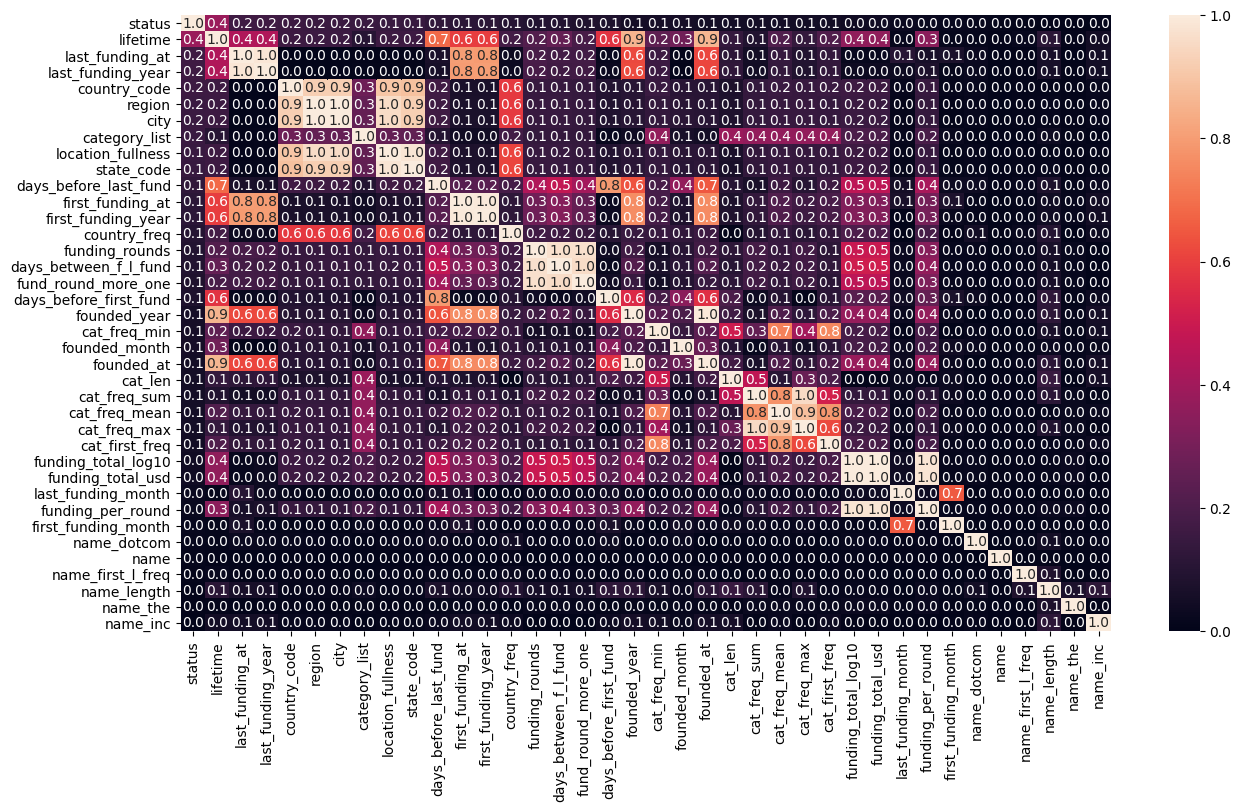

'time 10.61 sec.'

In [121]:
start = time.time()

train_scaled = y_train.to_frame().merge(
    X_train_scaled,
    how='left', 
    left_index=True, 
    right_index=True
)
train_corr = train_scaled.corr(method='spearman').abs()

seq = train_corr['status'].sort_values(ascending=False).index
train_corr = train_scaled[seq].corr(method='spearman').round(3).abs()

plt.rcParams['figure.figsize'] = (15,8)
sns.heatmap(train_corr, annot=True, fmt='.1f')
plt.show();

display(f'time {round(time.time() - start,2)} sec.')

Отсеем признаки, обладающие крайне низким влиянием на целевой признак:

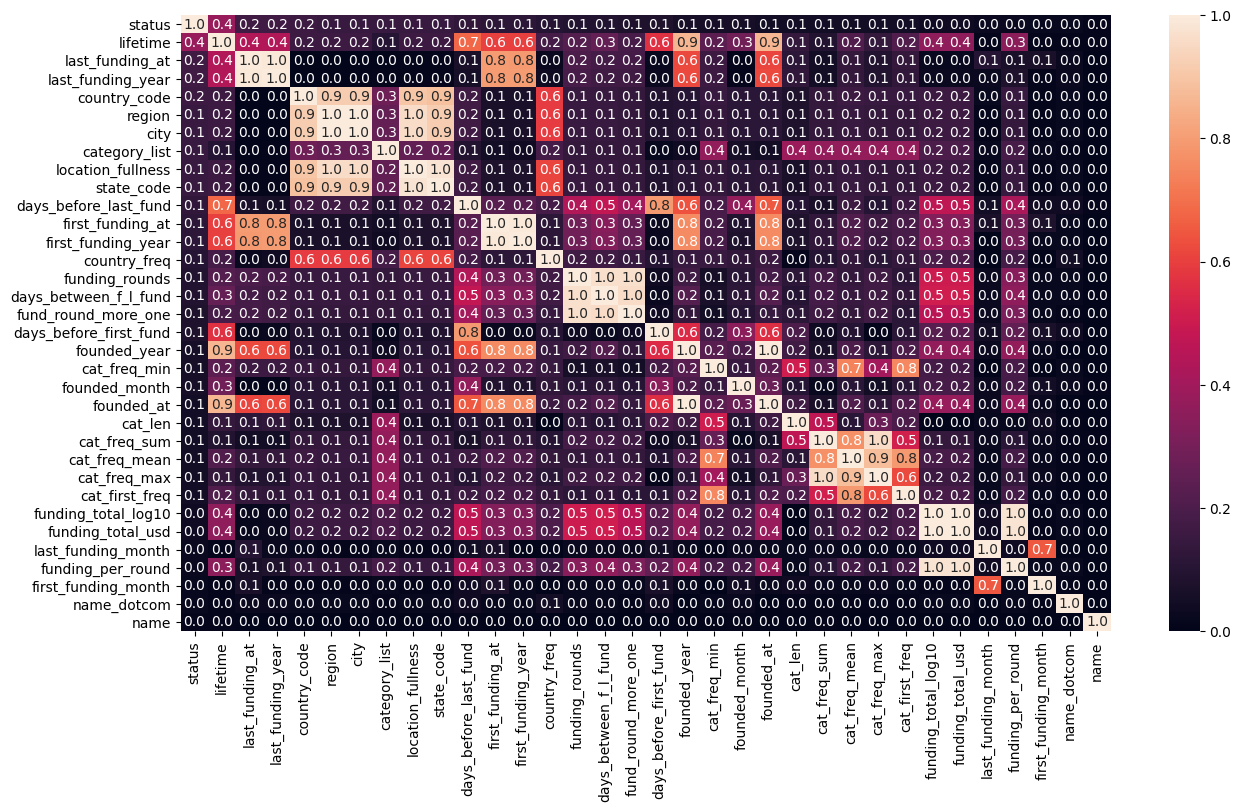

In [122]:
new_seq = train_corr.status[train_corr.status>0.01].index

train_corr = train_scaled[new_seq].corr(method='spearman').round(2).abs()

plt.rcParams['figure.figsize'] = (15,8)
sns.heatmap(train_corr, annot=True, fmt='.1f')
plt.show();

Теперь отберйм признаки с высокой взаимной корреляцией для отбора тех, кто останется для моделирования:

In [123]:
train_corr[train_corr>0.89][train_corr<1].unstack().dropna().sort_values(
    ascending=False)

last_funding_at        last_funding_year        0.99
first_funding_year     first_funding_at         0.99
first_funding_at       first_funding_year       0.99
last_funding_year      last_funding_at          0.99
location_fullness      state_code               0.98
funding_per_round      funding_total_log10      0.98
funding_total_usd      funding_per_round        0.98
funding_total_log10    funding_per_round        0.98
state_code             location_fullness        0.98
funding_per_round      funding_total_usd        0.98
funding_rounds         fund_round_more_one      0.97
fund_round_more_one    funding_rounds           0.97
funding_rounds         days_between_f_l_fund    0.97
days_between_f_l_fund  funding_rounds           0.97
location_fullness      region                   0.96
                       city                     0.96
city                   location_fullness        0.96
cat_freq_max           cat_freq_sum             0.96
region                 location_fullness      

удаляемые запишем в список, остальные сохраним:

In [124]:
removed_ = ['first_funding_year', 'first_funding_month', 
            'last_funding_year', 'last_funding_month',
            'founded_at', 
            'state_code', 'region', 'city',
            'fund_round_more_one', 
            'cat_freq_sum',
            'funding_total_log10', 'funding_per_round',
            'name',
           ]

selected_seq = []
for f in new_seq:
    if f in removed_:
        pass
    else:
        selected_seq.append(f)
display(selected_seq)

['status',
 'lifetime',
 'last_funding_at',
 'country_code',
 'category_list',
 'location_fullness',
 'days_before_last_fund',
 'first_funding_at',
 'country_freq',
 'funding_rounds',
 'days_between_f_l_fund',
 'days_before_first_fund',
 'founded_year',
 'cat_freq_min',
 'founded_month',
 'cat_len',
 'cat_freq_mean',
 'cat_freq_max',
 'cat_first_freq',
 'funding_total_usd',
 'name_dotcom']

Ещё раз построим матрицу корреляции на  итоговом наборе признаков:

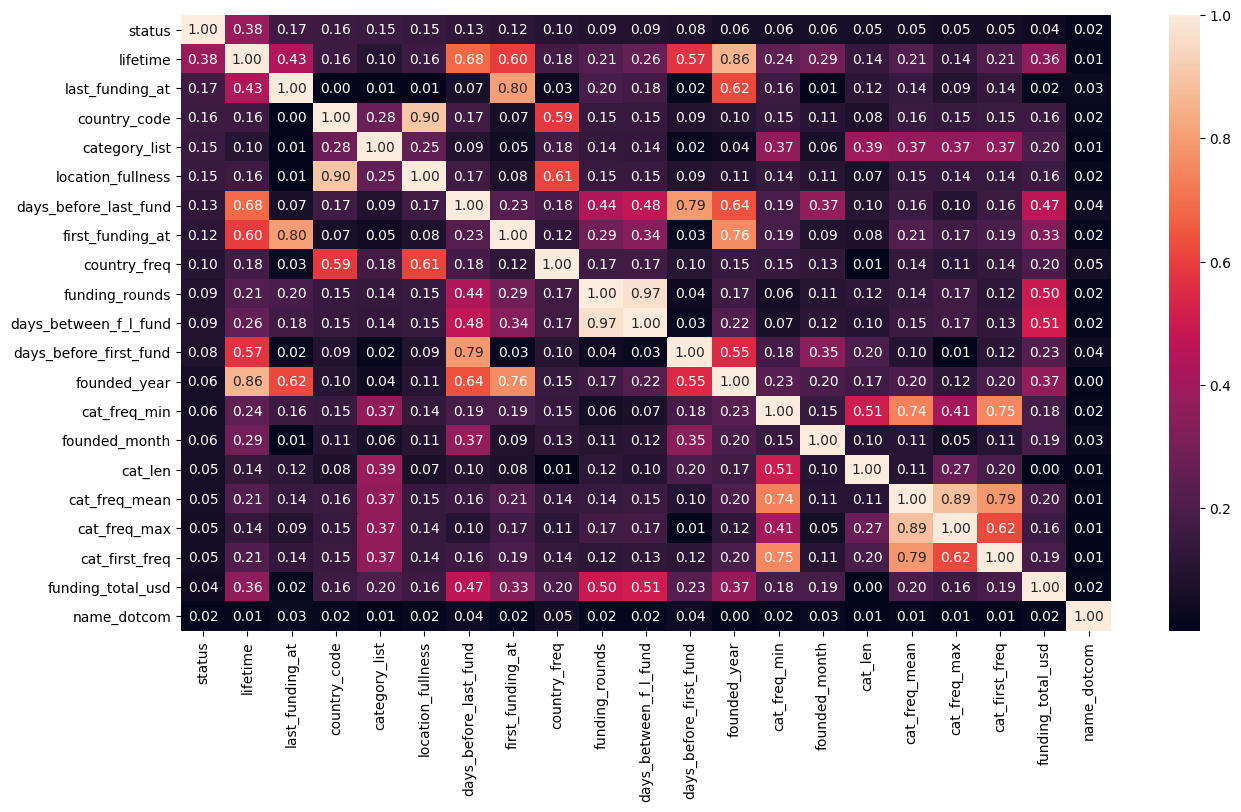

In [125]:
train_corr = train_scaled[selected_seq].corr(method='spearman').round(3).abs()

plt.rcParams['figure.figsize'] = (15,8)
sns.heatmap(train_corr, annot=True, fmt='.2f')
plt.show();

<b>Выводы :</b> <br>
На этапе проверки на мультиколлинеарность отобраны признаки для использования в моделировании, <br>
устранены малозначимые для целевого и взаимно мультиколлинеарные.

In [126]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 22.42'

# отбор финального набора обучающих признаков

In [127]:
block_start = time.time()

Факторы сократим до отобранных на этапе проверки на мультиколлинеарность, <br>
в обучающих данных очистим полные дубликаты:

In [128]:
train_ss = pd.concat([X_train_scaled[selected_seq[1:]], 
                      y_train], axis=1) # scaled, selected
display(train_ss.shape)
train_ssdd = train_ss.drop_duplicates() # scaled, selected, dropped duplicates
display(train_ssdd.shape)
X_train_ssdd = train_ssdd.drop(columns='status')
y_train_dd = train_ssdd.status # dropped duplicates
X_test_ss = X_test_scaled[selected_seq[1:]] # scaled, selected

display(X_train_ssdd.shape, X_test_ss.shape)

(52514, 21)

(52498, 21)

(52498, 20)

(13125, 20)

Данные готовы для МО и определения лучшей модели.

In [129]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 0.08'

# Обучение Моделей 

In [130]:
block_start = time.time()

Создадим пайплайн с моделями и сеткой гиперпараметров для поиска:

In [131]:
search = Pipeline([('models', KNeighborsClassifier())])

knn_metrics = ['euclidean', 'cityblock', 'minkowski']
knn_n = range(2,10,1)
dtc_max_depth = range(2, 11)
svc_kernel = ['linear', 
#              'poly', 
              'rbf', 'sigmoid']
logc_penalty = ['l1', 'l2']

parametrs = [
    {
        'models': [KNeighborsClassifier()], 
        'models__metric': ['minkowski'], 
        'models__n_neighbors': [3],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RS, 
                                          class_weight='balanced')], 
        'models__max_depth': [8,9,10],
    },
    {
        'models': [SVC(random_state=RS, 
                       degree=2, 
                       probability=True, 
                       class_weight='balanced')], 
        'models__kernel': ['linear', 'poly', 'rbf'],
    },
#    {'models': [LogisticRegression(random_state=RS, 
#    solver='saga', max_iter=100, class_weight='balanced')], 
#    'models__penalty': logc_penalty,},
]

grid_search = GridSearchCV(search,
                           param_grid=parametrs, 
                           cv=5,
                           scoring='f1',
#                           n_jobs=-1,
                          )

Запускаем сплошной подбор гиперпараметров и моделей:

In [132]:
start = time.time()
grid_search.fit(X_train_ssdd, y_train_dd)
display(f'time {round(time.time() - start,2)} sec.')

'time 2058.28 sec.'

Модели просчитаны, отобразим результаты: 

In [133]:
result = pd.DataFrame(grid_search.cv_results_)

select = ['rank_test_score', 
          'mean_test_score', 
          'mean_fit_time', 
          'params',
         ]

result[select].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,mean_fit_time,params
4,1,0.998981,12.516239,"{'models': SVC(class_weight='balanced', degree=2, kernel='linear', probability=True, random_state=42), 'models__kernel': 'linear'}"
6,2,0.976782,89.994221,"{'models': SVC(class_weight='balanced', degree=2, kernel='linear', probability=True, random_state=42), 'models__kernel': 'rbf'}"
3,3,0.973086,0.174030,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 10}"
5,4,0.970385,290.888380,"{'models': SVC(class_weight='balanced', degree=2, kernel='linear', probability=True, random_state=42), 'models__kernel': 'poly'}"
1,5,0.962150,0.168209,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 8}"
2,6,0.956216,0.169968,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 9}"
0,7,0.765805,0.008407,"{'models': KNeighborsClassifier(), 'models__metric': 'minkowski', 'models__n_neighbors': 3}"


Отобразим лучшую модель и её гиперпараметры:

In [134]:
model_best = grid_search.best_estimator_.named_steps['models']
display(model_best)

SVC(class_weight='balanced', degree=2, kernel='linear', probability=True,
    random_state=42)

Рассчитаем пробы (вероятности отнесения к целевому классу) для тестовых данных:

In [135]:
test_probas = model_best.predict_proba(X_test_ss)[0:,1]
display(pd.Series(test_probas).round(2).value_counts().sort_index())

0.00    11796
0.01       85
0.02       10
0.03        1
0.45        1
0.62        1
0.76        1
0.93        1
0.94        1
0.97        2
0.98        4
0.99        6
1.00     1216
dtype: int64

Сранвим с проверочным (целевым) значением целевого признака.

In [136]:
y_test.value_counts()

0    11892
1     1233
Name: status, dtype: int64

Рассчитаем метрику f1 для полученных проб:

In [137]:
score = f1_score(y_test.astype(int), test_probas.round(0).astype(int))
display(f'Значение метрики f1 для лучшей модели равно {score:.4f}')

'Значение метрики f1 для лучшей модели равно 0.9996'

<b>Выводы:</b> <br>
Поиск по моделям и гиперпараметрам произведён, <br>
Определена лучшая модель, <br>
рассчитаны вероятности отнесения наблюдений тестовой выборки к целевому классу.

In [138]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 2058.69'

# Оценка качества и предсказание

In [139]:
block_start = time.time()

Для перевода предсказаний в целевой формат, воспользуемся кодировщиком целевого признака:

In [140]:
_ = pd.Series(sorted(data.status.value_counts().index, reverse=True))
le = LabelEncoder().fit(_)
display(le.classes_)

array(['closed', 'operating'], dtype=object)

Переведём проверочные значения целевого признака в итоговый текстовый формат:

In [141]:
target = pd.Series(le.inverse_transform(1-y_test), name='status')
display(target.value_counts(),
        POS_LABEL)

operating    11892
closed        1233
Name: status, dtype: int64

'closed'

Рассчитаем порог вероятности отнесения наблюдения к целевому классу, <br>
максимизирующий целевую метрику f1:

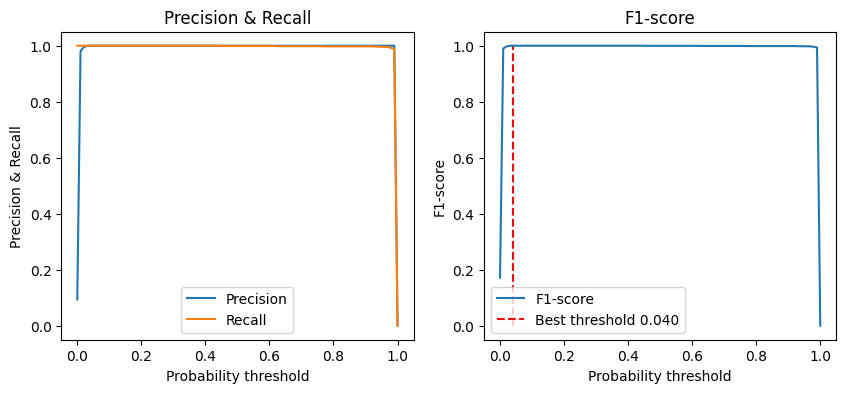

'time 23.05 sec.'

In [142]:
start = time.time()

threshold = np.linspace(0, 1, 100)
presisions = []
recalls = []
f1 = []

for p in threshold:
    predicted = np.where(test_probas > p, 
                         POS_LABEL, 'operating').tolist()
    presisions.append(precision_score(
        target, predicted, pos_label=POS_LABEL, 
        zero_division=0))
    recalls.append(recall_score(
        target, predicted, pos_label=POS_LABEL, 
        zero_division=0))
    f1.append(f1_score(
        target, predicted, pos_label=POS_LABEL, 
        zero_division=0))
    
max_f1_idx = np.argmax(np.array(f1))
best_threshold = threshold[max_f1_idx]
predicted = np.where(test_probas >= best_threshold, 
                     POS_LABEL, 'operating').tolist()

plt.rcParams['figure.figsize'] = (10,4)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(threshold, presisions, label='Precision')
axes[0].plot(threshold, recalls, label='Recall')
axes[1].plot(threshold, f1, label='F1-score')
axes[1].vlines(best_threshold, 0, 1, 
               linestyles="--", color='r', 
               label=f'Best threshold {best_threshold:.3f}')
axes[0].legend()
axes[1].legend()
axes[0].set_title('Precision & Recall')
axes[1].set_title('F1-score')
axes[0].set_ylabel('Precision & Recall')
axes[1].set_ylabel('F1-score')
axes[0].set_xlabel('Probability threshold')
axes[1].set_xlabel('Probability threshold')
plt.show();
display(f'time {round(time.time() - start,2)} sec.')

Порог определён, теперь запишем предсказание в переменную, подсчитаем количество "закрытых" стартапов в тестовых данных:

In [143]:
try_2 = pd.DataFrame(predicted, columns=['status'])
display(try_2.value_counts())

status   
operating    11892
closed        1233
dtype: int64

Объединим с проверочным целевым значением и наименованиями стартапов из примера:

In [144]:
compare = sample.merge(
    target, 
    how='left', 
    left_index=True, 
    right_index=True, 
    suffixes=('_sample', '_test')
).merge(try_2, 
        how='left', 
        left_index=True, 
        right_index=True)
display(compare.sample(5))

,name,status_sample,status_test,status
5768,HotDesk,operating,operating,operating
10357,Simply Zesty,operating,operating,operating
6787,MemberPlanet,operating,operating,operating
5026,Harmonix Music Systems,operating,operating,operating
8156,G plus games,operating,operating,operating


Построим сводную таблицу (матрицу ошибок):

In [145]:
pd.pivot_table(compare, 
               values='name', 
               index='status_test', 
               columns='status', 
               aggfunc='count', 
               fill_value=None, 
               margins=False, 
               dropna=True, 
               margins_name='All')

status,closed,operating
status_test,,
closed,1233.0,NaN
operating,NaN,11892.0


Убираем статусы из примера  полученные из дат, <br>
оставляем только предсказанное значение с учётом рассчитанного порога отнесения к целевому классу:

In [146]:
try_2_sample = compare.drop(columns=['status_sample','status_test'])
display(try_2_sample.sample(5))

,name,status
3391,Kinvision,operating
4768,Aloqa,operating
8338,Scrapblog,operating
2054,Streamline Alliance,operating
3737,Skoop,operating


Ещё раз отобразим количество итоговых преедсказаний для контроля:

In [147]:
try_2_sample.status.value_counts()

operating    11892
closed        1233
Name: status, dtype: int64

Записываем полученные предсказания в файл:

<b>Выводы:</b><br>
На данном этапе полученные вероятности отнесения к целевому классу <br>
были преобразованы в целевой текстовый формат <br>
с использованием порога отнесения, максимизирующего целевую метрику.

In [148]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 23.23'

# Анализ Важности Признаков

In [149]:
block_start = time.time()

Выбранная на этапе поиска лучшая модель <br>
определяет требуемую модель библиотеки SHAP, работующую с МО.

In [150]:
display(model_best)

SVC(class_weight='balanced', degree=2, kernel='linear', probability=True,
    random_state=42)

Для анализа важности признаков <br>
рассчитаем и запишем в переменную вероятности отнесения к целевому классу (пробы) <br>
для обучающей выборки:

In [151]:
y_train_dd_proba = pd.Series(model_best.predict_proba(X_train_ssdd)[0:,1], 
                             index=X_train_ssdd.index, 
                             name='proba')
shap_test = pd.concat([X_train_ssdd, y_train_dd, y_train_dd_proba], axis=1)
shap_test.status.value_counts()

0    47583
1     4915
Name: status, dtype: int64

Так как исходная обучающая выборка не была сбаллснсирована по целевому признаку, <br>
для упрощения работы с анализом важности признаков, сбаллансируем её, <br>
оставив из мажорного класса такое же количество наблюдений, как было в минорном:

In [152]:
n_balance = shap_test.status.value_counts()[1] 
# количество минорных наблюдений
shap_majority = shap_test[shap_test.status==0].sort_values(
    by='proba').head(n_balance)
shap_test = pd.concat([shap_test[shap_test.status==1], 
                       shap_majority], axis=0) 
# сбаллансированная выборка

Ввиду особенностей работы библиотеки SHAP, придётся ещё сократить количество наблюдений:

In [153]:
KernelExplainer_LIMIT = 100 
# если больше 100 наблюдений, SHAP работает слишком долго
shap_test = shap_test.sample(KernelExplainer_LIMIT, random_state=RS)
X_train_shap = shap_test[X_train_ssdd.columns]
y_proba_shap = shap_test.status

display(X_train_shap.shape, y_proba_shap.shape)

(100, 20)

(100,)

Проверим сбаллансированность целевого признака после сэмплирования:

In [154]:
display(shap_test.status.value_counts())

1    54
0    46
Name: status, dtype: int64

Запускаем расчёт shap-значений:

In [155]:
start = time.time()
explainer = shap.KernelExplainer(model_best.predict_proba, X_train_shap)
explainer.feature_names = X_train_shap.columns
shap_values = explainer(X_train_shap)
display(f'time {round(time.time() - start,2)} sec.')

  0%|          | 0/100 [00:00<?, ?it/s]

'time 930.36 sec.'

Построим столбчатую диаграмму важных признаков модели:

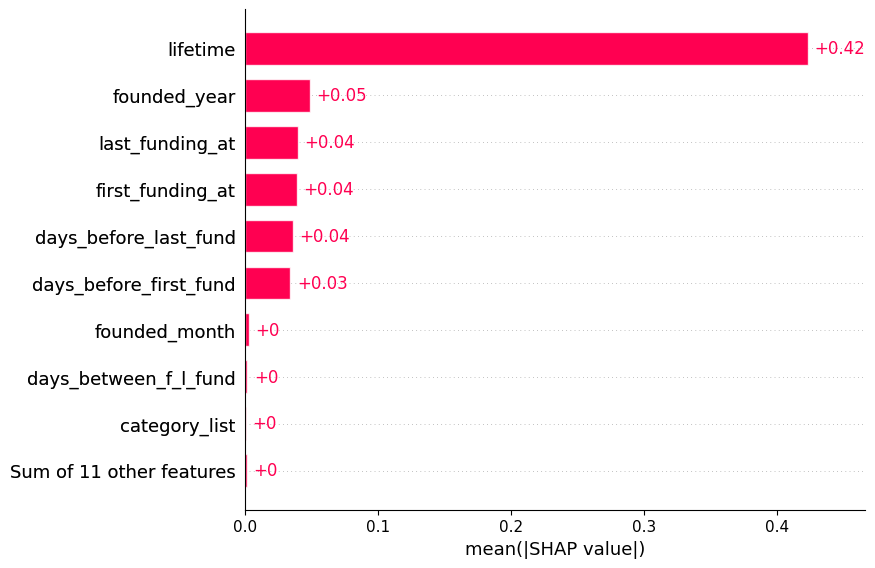

In [156]:
plt.rcParams['figure.figsize'] = (4,4)
shap.plots.bar(shap_values[:,:,0]);

Запишем важные признаки в список:

In [157]:
shap_top_features = [
    'lifetime', 
    'founded_year', 
    'days_before_last_fund', 
    'first_funding_at', 
    'days_before_first_fund', 
    'last_funding_at', 
    ]

Теперь отберём закрытый стартап для примера: 

In [158]:
display(shap_test.reset_index(drop=True).sort_values(by='proba').tail(5))

,lifetime,last_funding_at,country_code,category_list,location_fullness,days_before_last_fund,first_funding_at,country_freq,funding_rounds,days_between_f_l_fund,days_before_first_fund,founded_year,cat_freq_min,founded_month,cat_len,cat_freq_mean,cat_freq_max,cat_first_freq,funding_total_usd,name_dotcom,status,proba
16,-0.990305,0.153202,1.0,1.0,0.377637,-0.544193,0.324782,-1.153489,0.188662,-0.352150,-0.438039,0.597600,-0.623316,-0.862105,0.365799,-0.043044,0.883232,1.506054,-0.062886,0.0,1,1.0
68,-1.292930,-0.971475,1.0,1.0,0.377637,-0.846916,-0.635673,-1.171273,-0.538859,-0.503179,-0.700433,0.076353,-0.635218,1.283197,1.942592,-0.461115,-0.035165,0.422749,-0.087002,0.0,1,1.0
69,-1.207264,-1.620107,1.0,1.0,0.377637,-0.744881,-1.234918,0.875572,-0.538859,-0.503179,-0.590748,-0.271145,-0.504840,-0.862105,-0.685397,-0.804813,-1.007964,-0.724727,-0.072748,0.0,1,1.0
71,-0.751929,0.302069,1.0,1.0,0.377637,-0.235832,0.540904,-0.991828,-0.538859,-0.503179,-0.043539,0.423851,-0.565430,-0.862105,0.891396,-0.327798,-0.133367,-0.785636,-0.086883,0.0,1,1.0
49,-1.129512,0.522096,1.0,1.0,0.377637,-0.559977,0.744179,-1.088420,-0.538859,-0.503179,-0.391983,0.771349,-0.001721,-0.057617,-0.685397,-0.270004,-0.579195,-0.218968,0.289528,0.0,1,1.0


lifetime                 -1.10437
founded_year              0.07635
days_before_last_fund    -0.58196
first_funding_at         -0.70066
days_before_first_fund   -0.76224
last_funding_at          -0.57395
status                    1.00000
proba                     1.00000
Name: 65, dtype: float64

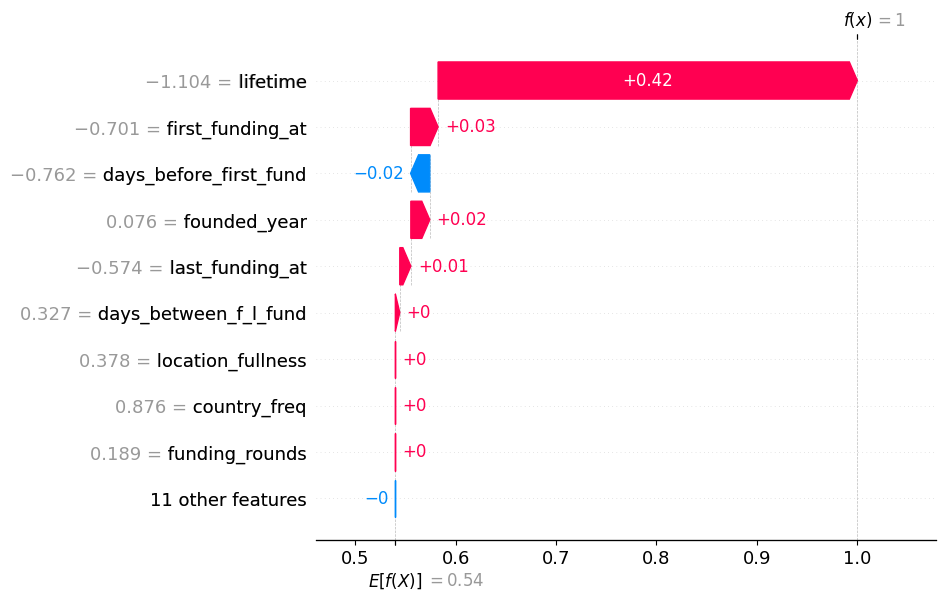

In [159]:
i=65
display(shap_test[shap_top_features+['status', 'proba']
        ].reset_index(drop=True).loc[i,:].round(5))
shap.plots.waterfall(shap_values[i,0:,1]);

И не закрытый:

In [160]:
display(shap_test.reset_index(drop=True).sort_values(by='proba').head(5))

,lifetime,last_funding_at,country_code,category_list,location_fullness,days_before_last_fund,first_funding_at,country_freq,funding_rounds,days_between_f_l_fund,days_before_first_fund,founded_year,cat_freq_min,founded_month,cat_len,cat_freq_mean,cat_freq_max,cat_first_freq,funding_total_usd,name_dotcom,status,proba
0,2.242197,-4.455930,1.0,1.0,0.377637,-0.470908,-3.854822,0.875572,-0.538859,-0.503179,-0.296237,-2.182384,-0.459397,-0.325779,-0.159799,-0.672836,-0.835073,-0.520792,-0.087596,0.0,0,1.000000e-07
37,0.979552,-1.908025,1.0,1.0,0.377637,-0.243724,-1.938446,0.875572,0.188662,0.337646,-0.402891,-0.966141,3.131143,1.015035,-0.685397,3.060186,2.090702,2.930338,0.066817,0.0,0,1.000000e-07
38,0.038155,-0.619758,0.0,1.0,-2.798029,-0.495712,-0.310735,-1.195822,-0.538859,-0.503179,-0.322900,0.076353,0.314217,-0.325779,-0.685397,0.065833,-0.309946,0.098628,-0.053150,1.0,0,1.000000e-07
39,0.479988,-1.391082,1.0,1.0,0.377637,-0.492330,-1.023331,-1.088420,-0.538859,-0.503179,-0.319264,-0.444894,0.570645,0.746872,-0.685397,0.338413,-0.091412,0.356402,-0.087596,0.0,0,1.000000e-07
41,0.067952,-0.726091,1.0,1.0,0.377637,-0.532918,-0.408972,0.875572,-0.538859,-0.503179,-0.362896,0.076353,1.319373,-0.862105,-0.685397,1.134300,0.546671,1.109060,-0.069779,0.0,0,1.000000e-07


lifetime                 -0.42184
founded_year              0.42385
days_before_last_fund    -0.75052
first_funding_at          0.09430
days_before_first_fund   -0.59681
last_funding_at          -0.18134
status                    0.00000
proba                     0.00000
Name: 54, dtype: float64

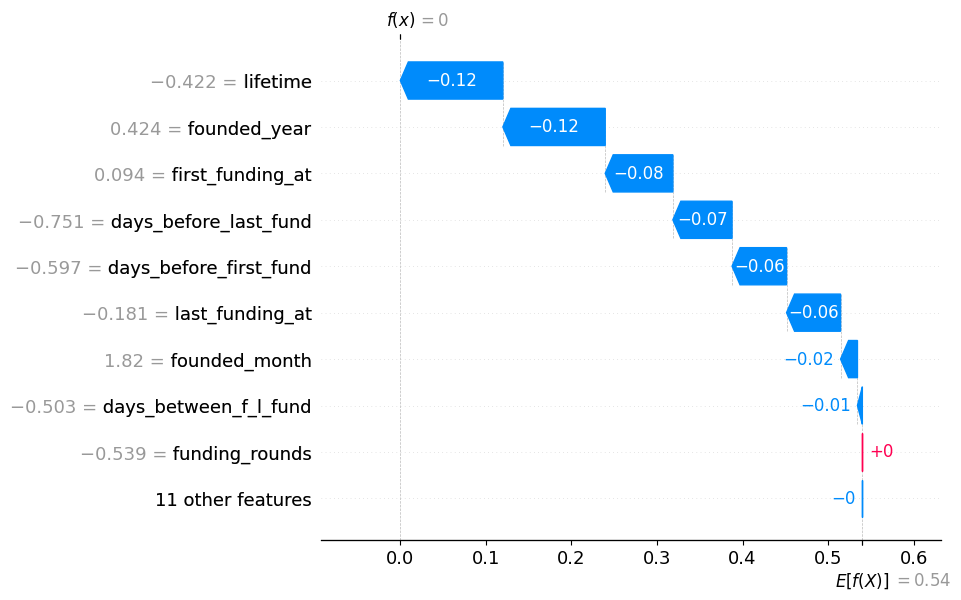

In [161]:
i=54
display(shap_test[shap_top_features+['status', 'proba']
        ].reset_index(drop=True).loc[i,:].round(5))
shap.plots.waterfall(shap_values[i,0:,1])

<b>Выводы:</b><br>
Анализ важности признаков указывает на то, что <br>
наибольший вес для модели имел признак "срока жизни" стартапа, <br>
рассчитанный для исходных обучающих данных по аналогии с тестовыми.

In [162]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 935.41'

# Линейнная модель

In [163]:
block_start = time.time()

In [164]:
display(X_train_ssdd.shape, y_train_dd.shape)

(52498, 20)

(52498,)

Попробуем разработать предсказание закрытия стратапов, предсказывая их срок жизни, <br>
и сравнивая его в последующем с датой основания и текущей датой.

Для этого изменим значение "срока жизни" как целевого признака, <br>
но для незакрытых стартапов, установим "бесконечно долгую" жизнь - 250 лет...

In [165]:
ETERNAL_LIFETIME = int(250*365.25)
display(pd.to_timedelta(ETERNAL_LIFETIME, 'days'))

Timedelta('91312 days 00:00:00')

Соберём целевой признак в таблицу:

In [166]:
y_lin_train = pd.concat([
    train_dates.lifetime[X_train_ssdd.index], 
    train_dates.founded_at[X_train_ssdd.index], 
    pd.Series(y_train_dd, 
              index=y_train_dd.index, 
              name='status_encoded'), 
    data.status[X_train_ssdd.index]
], axis=1)

y_lin_train['lifetime_eternal'] = np.where(
    y_lin_train.status_encoded == 0, 
    ETERNAL_LIFETIME, 
    y_lin_train.lifetime
)

display(y_lin_train[y_lin_train.status_encoded==1])

,lifetime,founded_at,status_encoded,status,lifetime_eternal
12,929,2013-01-07,1,closed,929
16,670,2013-01-01,1,closed,670
23,1030,2012-04-12,1,closed,1030
24,422,2015-01-01,1,closed,422
29,1033,1999-05-20,1,closed,1033
...,...,...,...,...,...
52451,810,2011-08-01,1,closed,810
52453,1068,2014-04-24,1,closed,1068
52454,2343,2006-03-01,1,closed,2343
52457,5589,1999-01-01,1,closed,5589


In [167]:
display(X_test_ss.shape, y_test.shape)

(13125, 20)

(13125,)

Сделаем то же для тестовых данных:

In [168]:
y_lin_test = pd.concat([
    test_dates.lifetime, 
    test_dates.founded_at, 
    pd.Series(y_test, 
              index=y_test.index, 
              name='status_encoded'), 
    target
], axis=1)

y_lin_test['lifetime_eternal'] = np.where(
    y_lin_test.status_encoded == 0, 
    ETERNAL_LIFETIME, 
    y_lin_test.lifetime
)

y_lin_test['datediff'] = (CURRENT_DATE - y_lin_test.founded_at).dt.days

y_lin_test[y_lin_test.status_encoded==1]

,lifetime,founded_at,status_encoded,status,lifetime_eternal,datediff
19,1777,2006-01-01,1,closed,1777,4383
31,487,2010-10-10,1,closed,487,2640
53,1086,1999-04-05,1,closed,1086,6846
60,961,2010-01-18,1,closed,961,2905
80,988,2012-01-14,1,closed,988,2179
...,...,...,...,...,...,...
13054,1184,2011-06-10,1,closed,1184,2397
13057,665,2015-01-01,1,closed,665,1096
13059,602,2008-11-01,1,closed,602,3348
13073,1143,2007-01-01,1,closed,1143,4018


Оставим только целевой признак:

In [169]:
y_lin_train_ = y_lin_train.lifetime_eternal
y_lin_test_ = y_lin_test.lifetime_eternal

In [170]:
X_lin_train = X_train_ssdd.drop(columns='lifetime')
X_lin_test = X_test_ss.drop(columns='lifetime')

Запустим модель линейной регрессии, получим предсказания:

In [171]:
start = time.time()
model_lr = LinearRegression()
model_lr.fit(X_lin_train, y_lin_train_)
y_lin_pred = pd.Series(model_lr.predict(X_lin_test), name='predict')
display(f'time {round(time.time() - start,2)} sec.')

'time 0.06 sec.'

Объединим предсказания в таблицу для сравнения:

In [172]:
y_lin_test = y_lin_test.merge(y_lin_pred.round(0).astype(int), 
                              how='left', 
                              left_index=True, right_index=True)
y_lin_test['linear_proba'] = np.where(
    y_lin_test.predict > y_lin_test.datediff, 
    1, 
    y_lin_test.predict/y_lin_test.datediff
)

display(y_lin_test[y_lin_test.status_encoded==1])

,lifetime,founded_at,status_encoded,status,lifetime_eternal,datediff,predict,linear_proba
19,1777,2006-01-01,1,closed,1777,4383,80042,1.0
31,487,2010-10-10,1,closed,487,2640,80033,1.0
53,1086,1999-04-05,1,closed,1086,6846,57399,1.0
60,961,2010-01-18,1,closed,961,2905,83324,1.0
80,988,2012-01-14,1,closed,988,2179,62201,1.0
...,...,...,...,...,...,...,...,...
13054,1184,2011-06-10,1,closed,1184,2397,84333,1.0
13057,665,2015-01-01,1,closed,665,1096,87419,1.0
13059,602,2008-11-01,1,closed,602,3348,78317,1.0
13073,1143,2007-01-01,1,closed,1143,4018,79022,1.0


Отдельно посмотрим на описательную статистику закрытых и не закрытых стартапов:

In [173]:
y_lin_test[y_lin_test.status_encoded==0].describe().round(1)

,lifetime,status_encoded,lifetime_eternal,datediff,predict,linear_proba
count,11892.0,11892.0,11892.0,11892.0,11892.0,11892.0
mean,3280.0,0.0,91312.0,3280.0,83484.1,1.0
std,2114.7,0.0,0.0,2114.7,6502.9,0.0
min,798.0,0.0,91312.0,798.0,29042.0,1.0
25%,1826.0,0.0,91312.0,1826.0,81134.2,1.0
50%,2557.0,0.0,91312.0,2557.0,85362.0,1.0
75%,4018.0,0.0,91312.0,4018.0,87560.0,1.0
max,17167.0,0.0,91312.0,17167.0,100469.0,1.0


In [174]:
y_lin_test[y_lin_test.status_encoded==1].describe().round(1)

,lifetime,status_encoded,lifetime_eternal,datediff,predict,linear_proba
count,1233.0,1233.0,1233.0,1233.0,1233.0,1233.0
mean,1344.8,1.0,1344.8,3579.4,76377.0,1.0
std,1304.3,0.0,1304.3,2071.2,10050.0,0.0
min,79.0,1.0,79.0,776.0,19697.0,1.0
25%,721.0,1.0,721.0,2149.0,72821.0,1.0
50%,997.0,1.0,997.0,3215.0,78721.0,1.0
75%,1351.0,1.0,1351.0,4408.0,83183.0,1.0
max,14831.0,1.0,14831.0,17167.0,97328.0,1.0


К сожалению, дял всех наблюдений тестовой выборки <br>
срок жизни был спрогнозирован намного больше, чем требовалось для категоризации как "закрывшихся"

In [176]:
y_lin_test.linear_proba.value_counts()

1.0    13125
Name: linear_proba, dtype: int64

In [177]:
_ = time.time() - block_start
display(f'block_time = {round(_, 2)}')

'block_time = 40.36'

# Итоговый Вывод

**Цель и задачи:** <br>
Главная цель данной исследовательской работы – поиск факторов для прогозирования (преждевременного) закрытия стартапов, запрашивающих финансирование. <br>
В достижении этой цели сформулированы две задачи: построение модели машинного обучения, прогнозирующей закрытие <br>
и выделение важных факторов, влияющих на вероятность закрытия. <br>
Методом решения этих задач определён поиск оптимальных моделей машинного обучения для предсказания целевого признака - статуса закрытого стартапа.

<b>Этапы:</b> <br>
Для решения использовались следующие этапы работы:<br>
1. загрузка данных;
2. предобработка и заполнение пропущенных значений;
3. разработка новых факторов из имеющихся данных;
4. Подготовка данных: масштабирование и кодирование (бинарных синтетических признаков);
5. Корреляционный анализ и отбор признаков для обучения;
6. Собственно обучение моделей и выбор лучшей;
7. Оценка качества предсказания, определение порога отнесения к классам;
8. Анализ важности признаков.

<b>Выводы:</b> <br>
1. Для предсказания закрытия стартапов использовались модели классификации (kNN, SVC и DecisionTreeClassifier). <br>
Лучшее значение метрики f1 получилось у модели метода опорных вектооров SVC. <br>

2. Среди важных факторов для определения закрытия выделены:<br>
- дата основания стартапа;
- Даты первого и последнего финансирования;   
- Разница межды датами открытия и началом финансирования;
- Разница межды датами открытия и окончанием финансирования<br>

In [178]:
_ = time.time() - very_start_time
display(f'full_time = {round(_, 2)}')

'full_time = 3097.15'